In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
import time
import sklearn
from random import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from tabulate import tabulate
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier

evaluate={'Acc':"Accuracy", 'b_Acc':"Balanced Accuracy", 'F1':"F1 Score", 'kap':"Kappa", 'ROC':"Roc"}

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost

In [6]:
def GA(train,test,cols,gen_number=25,outputcsv="GA_output.csv"):
    #defining various steps required for the genetic algorithm
    # GA adapted from https://datascienceplus.com/genetic-algorithm-in-machine-learning-using-python/
    def initilization_of_population(size,n_feat):
        population = []
        for i in range(size):
            chromosome = np.ones(n_feat,dtype=np.bool)
            chromosome[:int(0.3*n_feat)]=False
            np.random.shuffle(chromosome)
            population.append(chromosome)
        return population

    def fitness_score(population):
        scores = []
        for chromosome in population:
            logmodel.fit(X_train.iloc[:,chromosome],y_train)
            predictions = logmodel.predict(X_test.iloc[:,chromosome])
            scores.append(sklearn.metrics.f1_score(y_test,predictions,average= "macro"))
        scores, population = np.array(scores), np.array(population) 
        inds = np.argsort(scores)
        return list(scores[inds][::-1]), list(population[inds,:][::-1])

    def selection(pop_after_fit,n_parents):
        population_nextgen = []
        for i in range(n_parents):
            population_nextgen.append(pop_after_fit[i])
        return population_nextgen

    def crossover(pop_after_sel):
        population_nextgen=pop_after_sel
        for i in range(len(pop_after_sel)):
            child=pop_after_sel[i]
            child[3:7]=pop_after_sel[(i+1)%len(pop_after_sel)][3:7]
            population_nextgen.append(child)
        return population_nextgen

    def mutation(pop_after_cross,mutation_rate):
        population_nextgen = []
        for i in range(0,len(pop_after_cross)):
            chromosome = pop_after_cross[i]
            for j in range(len(chromosome)):
                if random.random() < mutation_rate:
                    chromosome[j]= not chromosome[j]
            population_nextgen.append(chromosome)
        #print(population_nextgen)
        return population_nextgen

    def generations(size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                       X_test, y_train, y_test):

        best_chromo= []
        best_score= []
        population_nextgen=initilization_of_population(size,n_feat)
        for i in range(n_gen):
            second=time.time()
            scores, pop_after_fit = fitness_score(population_nextgen)
            #print(scores[:2])
            zaman=time.time()-second

            ths.write(f"{np.mean(scores)},{np.mean(scores)},{zaman}\n")
            


            pop_after_sel = selection(pop_after_fit,n_parents)
            pop_after_cross = crossover(pop_after_sel)
            population_nextgen = mutation(pop_after_cross,mutation_rate)
            best_chromo.append(pop_after_fit[0])
            best_score.append(scores[0])
        return best_chromo,best_score
    
    



    df = pd.read_csv(train,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_train =df[df.columns[0:-1]]
    #X_train=np.array(X_train)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_train=df[df.columns[-1]].cat.codes  
    df = pd.read_csv(test,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_test =df[df.columns[0:-1]]
    #X_test=np.array(X_test)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_test=df[df.columns[-1]].cat.codes  

    
    ths = open(f"./{outputcsv}", "w")
    ths.write("MEAN,STD,TIME\n")
    logmodel=DecisionTreeClassifier()
    #print ('%-30s %-30s %-30s' % ("MEAN","STD","TIME"))
    chromo,score=generations(size=200,n_feat=X_train.shape[1],n_parents=120,mutation_rate=0.005,
                         n_gen=gen_number,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
    #logmodel.fit(X_train.iloc[:,chromo[-1]],y_train)
    #predictions = logmodel.predict(X_test.iloc[:,chromo[-1]])
    #print("F1 Score score after genetic algorithm is= "+str(sklearn.metrics.f1_score(y_test,predictions,average= "macro")))
    ths.close()
    sonuç=[]
    for k,j in enumerate(chromo):
        temp=X_train.iloc[:,j]
        temp=list(temp.columns)
        temp.append("Label")
        sonuç.append(temp)
    
    np.save(outputcsv.replace("csv","npy"), sonuç)
    gf = pd.read_csv(outputcsv)
    gf=gf["MEAN"].values
    gf=np.argmax(gf) 
    return sonuç[gf],gf

In [7]:
def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

In [8]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
    return files_add

In [9]:
ml_list={"LR":{"SYN":LogisticRegression(C=3.12528 ,penalty="none",solver="lbfgs" ),
               "HTTP":LogisticRegression(C=1.39267 ,penalty="l1",solver="liblinear" ),
               "ACK":LogisticRegression(C=  0.000174804,penalty="none",solver="lbfgs" ),    
               "UDP":LogisticRegression(C=0.000508345 ,penalty="none",solver="lbfgs" ),    
               "ARP":LogisticRegression(C= 7.21375e-05,penalty="l2",solver="newton-cg" ),
               "SP":LogisticRegression(C=50.8013 ,penalty="l1",solver="liblinear" ),    
               "BF":LogisticRegression(C= 5.70815e-05,penalty="l2",solver="liblinear" )    
              },

         

"DT":{"SYN":DecisionTreeClassifier(criterion="gini",max_depth=5,max_features=35,min_samples_split=6 ),
"HTTP":DecisionTreeClassifier(criterion="entropy",max_depth=16,max_features=2,min_samples_split=2),                      
"ACK":DecisionTreeClassifier(criterion="gini",max_depth=5,max_features=2,min_samples_split=8 ),            
"UDP":DecisionTreeClassifier(criterion="entropy",max_depth=3,max_features=11,min_samples_split=2 ),            
"ARP":DecisionTreeClassifier(criterion="entropy",max_depth=28,max_features=27,min_samples_split=2 ),            
"SP":DecisionTreeClassifier(criterion="gini",max_depth=4,max_features=16,min_samples_split=9 ),            
"BF":DecisionTreeClassifier(criterion="gini",max_depth=19,max_features=10,min_samples_split=3 )},
         

            
    
"RF":{"SYN":RandomForestClassifier(bootstrap=False,criterion="gini",max_depth=6,max_features=5,min_samples_split=9,n_estimators=73),
"HTTP":RandomForestClassifier(bootstrap=False,criterion="entropy",max_depth=14,max_features=9,min_samples_split=2,n_estimators=7),                      
"ACK":RandomForestClassifier(bootstrap=False,criterion="entropy",max_depth=4,max_features=9,min_samples_split=7,n_estimators=183 ),            
"UDP":RandomForestClassifier(bootstrap=False,criterion="gini",max_depth=6,max_features=5,min_samples_split=10,n_estimators=7 ),            
"ARP":RandomForestClassifier(bootstrap=False,criterion="entropy",max_depth=25,max_features=1,min_samples_split=3,n_estimators=48),            
"SP":RandomForestClassifier(bootstrap=False,criterion="entropy",max_depth=6,max_features=5,min_samples_split=6,n_estimators=29),            
"BF":RandomForestClassifier(bootstrap=True,criterion="entropy",max_depth=18,max_features=2,min_samples_split=2,n_estimators=125 )},      
             

         
"KNN":{"SYN":KNeighborsClassifier(algorithm="auto",leaf_size=42,n_neighbors=6,weights="distance"),
"HTTP":KNeighborsClassifier(algorithm="brute",leaf_size=7,n_neighbors=4,weights="distance"),                     
"ACK":KNeighborsClassifier(algorithm="auto",leaf_size=11,n_neighbors=4,weights="distance"),        
"UDP":KNeighborsClassifier(algorithm="auto",leaf_size=23,n_neighbors=4,weights="distance"),       
"ARP":KNeighborsClassifier(algorithm="ball_tree",leaf_size=5,n_neighbors=16,weights="distance"),         
"SP":KNeighborsClassifier(algorithm="kd_tree",leaf_size=33,n_neighbors=3,weights="distance"),         
"BF":KNeighborsClassifier(algorithm="kd_tree",leaf_size=38,n_neighbors=2,weights="distance")},
   
   
"SVM":{"SYN":SVC(gamma=0.001,C=1),
"HTTP":SVC(gamma=0.1,C=1),                  
"ACK":SVC(gamma=0.1,C=10),   
"UDP":SVC(gamma=1,C=10),   
"ARP":SVC(gamma=0.01,C=10),       
"SP":SVC(gamma=0.01,C=10),    
"BF":SVC(gamma=1,C=10)},
         
    
"MLP":{"SYN":MLPClassifier(solver= 'adam', learning_rate= 'constant', hidden_layer_sizes= (901, ), alpha= 0.1, activation='relu'),
"HTTP":MLPClassifier(solver= 'adam', learning_rate= 'constant', hidden_layer_sizes= (408,), alpha= 0.001, activation='tanh'),             
"ACK":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (95, ), alpha= 0.01, activation='relu'),
"UDP":MLPClassifier(solver= 'lbfgs', learning_rate= 'constant', hidden_layer_sizes= (1043, ), alpha= 0.0001, activation='tanh'),
"ARP":MLPClassifier(solver= 'sgd', learning_rate= 'adaptive', hidden_layer_sizes= (1637, ), alpha= 0.0001, activation='tanh'),    
"SP":MLPClassifier(solver= 'adam', learning_rate= 'constant', hidden_layer_sizes= (1533, ), alpha= 0.05, activation='relu'), 
"BF":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (892, 1585), alpha= 0.001, activation='tanh')},
         
         
"NB":{"SYN":GaussianNB(var_smoothing=2.84804e-06 ),
"HTTP":GaussianNB(var_smoothing= 2.84804e-09  ),                  
"ACK":GaussianNB(var_smoothing=1e-09  ),
"UDP":GaussianNB(var_smoothing=1e-09),  
"ARP":GaussianNB(var_smoothing=1e-09  ),    
"SP":GaussianNB(var_smoothing=2.31013e-09 ),      
"BF":GaussianNB(var_smoothing=0.1 )},      
         

         
"XGB":{"SYN":xgboost.XGBClassifier(n_estimators=100,min_child_weight=1,max_depth=2,learning_rate=0.15),
"HTTP":xgboost.XGBClassifier(n_estimators=1500,min_child_weight=1,max_depth=2,learning_rate=0.2),                 
"ACK":xgboost.XGBClassifier(n_estimators=1100,min_child_weight=1,max_depth=3,learning_rate=0.1),
"UDP":xgboost.XGBClassifier(n_estimators=500,min_child_weight=4,max_depth=2,learning_rate=0.05),
"ARP":xgboost.XGBClassifier(n_estimators=1100,min_child_weight=3,max_depth=3,learning_rate=0.2),    
"SP":xgboost.XGBClassifier(n_estimators=1500,min_child_weight=1,max_depth=2,learning_rate=0.1),   
"BF":xgboost.XGBClassifier(n_estimators=900,min_child_weight=2,max_depth=10,learning_rate=0.15)}}


In [10]:
ml_list={"LR":{"SYN":LogisticRegression(C=3.12528 ,penalty="none",solver="lbfgs" ),
               "HTTP":LogisticRegression(C=1.39267 ,penalty="l1",solver="liblinear" ),
               "ACK":LogisticRegression(C=  0.000174804,penalty="none",solver="lbfgs" ),    
               "UDP":LogisticRegression(C=0.000508345 ,penalty="none",solver="lbfgs" ),    
               "ARP":LogisticRegression(C= 7.21375e-05,penalty="l2",solver="newton-cg" ),
               "SP":LogisticRegression(C=50.8013 ,penalty="l1",solver="liblinear" ),    
               "BF":LogisticRegression(C= 5.70815e-05,penalty="l2",solver="liblinear" )    
              },

         

"DT":{"SYN":DecisionTreeClassifier(criterion="gini",max_depth=5,max_features=35,min_samples_split=6 ),
"HTTP":DecisionTreeClassifier(criterion="entropy",max_depth=16,max_features=2,min_samples_split=2),                      
"ACK":DecisionTreeClassifier(criterion="gini",max_depth=5,max_features=2,min_samples_split=8 ),            
"UDP":DecisionTreeClassifier(criterion="entropy",max_depth=3,max_features=11,min_samples_split=2 ),            
"ARP":DecisionTreeClassifier(criterion="entropy",max_depth=28,max_features=27,min_samples_split=2 ),            
"SP":DecisionTreeClassifier(criterion="gini",max_depth=4,max_features=16,min_samples_split=9 ),            
"BF":DecisionTreeClassifier(criterion="gini",max_depth=19,max_features=10,min_samples_split=3 )},
         

            
    
"RF":{"SYN":RandomForestClassifier(bootstrap=False,criterion="gini",max_depth=6,max_features=5,min_samples_split=9,n_estimators=73),
"HTTP":RandomForestClassifier(bootstrap=False,criterion="entropy",max_depth=14,max_features=9,min_samples_split=2,n_estimators=7),                      
"ACK":RandomForestClassifier(bootstrap=False,criterion="entropy",max_depth=4,max_features=9,min_samples_split=7,n_estimators=183 ),            
"UDP":RandomForestClassifier(bootstrap=False,criterion="gini",max_depth=6,max_features=5,min_samples_split=10,n_estimators=7 ),            
"ARP":RandomForestClassifier(bootstrap=False,criterion="entropy",max_depth=25,max_features=1,min_samples_split=3,n_estimators=48),            
"SP":RandomForestClassifier(bootstrap=False,criterion="entropy",max_depth=6,max_features=5,min_samples_split=6,n_estimators=29),            
"BF":RandomForestClassifier(bootstrap=True,criterion="entropy",max_depth=18,max_features=2,min_samples_split=2,n_estimators=125 )},      
             

         
"KNN":{"SYN":KNeighborsClassifier(algorithm="auto",leaf_size=42,n_neighbors=6,weights="distance"),
"HTTP":KNeighborsClassifier(algorithm="brute",leaf_size=7,n_neighbors=4,weights="distance"),                     
"ACK":KNeighborsClassifier(algorithm="auto",leaf_size=11,n_neighbors=4,weights="distance"),        
"UDP":KNeighborsClassifier(algorithm="auto",leaf_size=23,n_neighbors=4,weights="distance"),       
"ARP":KNeighborsClassifier(algorithm="ball_tree",leaf_size=5,n_neighbors=16,weights="distance"),         
"SP":KNeighborsClassifier(algorithm="kd_tree",leaf_size=33,n_neighbors=3,weights="distance"),         
"BF":KNeighborsClassifier(algorithm="kd_tree",leaf_size=38,n_neighbors=2,weights="distance")},
   
   
         
"NB":{"SYN":GaussianNB(var_smoothing=2.84804e-06 ),
"HTTP":GaussianNB(var_smoothing= 2.84804e-09  ),                  
"ACK":GaussianNB(var_smoothing=1e-09  ),
"UDP":GaussianNB(var_smoothing=1e-09),  
"ARP":GaussianNB(var_smoothing=1e-09  ),    
"SP":GaussianNB(var_smoothing=2.31013e-09 ),      
"BF":GaussianNB(var_smoothing=0.1 )},      
         

         
"XGB":{"SYN":xgboost.XGBClassifier(n_estimators=100,min_child_weight=1,max_depth=2,learning_rate=0.15),
"HTTP":xgboost.XGBClassifier(n_estimators=1500,min_child_weight=1,max_depth=2,learning_rate=0.2),                 
"ACK":xgboost.XGBClassifier(n_estimators=1100,min_child_weight=1,max_depth=3,learning_rate=0.1),
"UDP":xgboost.XGBClassifier(n_estimators=500,min_child_weight=4,max_depth=2,learning_rate=0.05),
"ARP":xgboost.XGBClassifier(n_estimators=1100,min_child_weight=3,max_depth=3,learning_rate=0.2),    
"SP":xgboost.XGBClassifier(n_estimators=1500,min_child_weight=1,max_depth=2,learning_rate=0.1),   
"BF":xgboost.XGBClassifier(n_estimators=900,min_child_weight=2,max_depth=10,learning_rate=0.15)}}


In [11]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [12]:
folder("results")
folder("pdfs")
folder("results/fin")
folder("models")


## Calculation of evaluations

In [13]:
def score(train_time,test_time,predict,y_test,class_based_results,repeat,cv,dname,ml,sw):
    train_time=train_time[0]
    test_time=test_time[0]
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=0
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,sw,repeat,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return class_based_results,line

In [14]:
def ML_CV(loop1,loop2,output_csv1,cols,dname,sw):
    fold=5
    repetition=2
    for ii in ml_list:
        output_csv=output_csv1.replace("ML",ii)
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        max_f1=0
        for i in range(repetition):

            rnd = random()
            
            kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            ##df = df.reset_index(drop=True)
            df=df.fillna(0)

            #del df["MAC"] # if dataset has MAC colomn please uncomment this line
            X =df[df.columns[0:-1]]
            X=np.array(X)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y=df[df.columns[-1]].cat.codes  
            X.shape
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]  



                #dname=loop1  [6:-13]  
                results_y=[]
                cv+=1
                results_y.append(y_test)


                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]

                    #machine learning algorithm is applied in this section
                clf = ml_list[ii][dname]#choose algorithm from ml_list dictionary
                second=time.time()
                clf.fit(X_train, y_train)
                train_time.append(float((time.time()-second)) )
                second=time.time()
                predict =clf.predict(X_test)
                test_time.append(float((time.time()-second)) )

                altime=0
                class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
                lines.append(line)
                df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
                if cm.empty:
                    cm =df_cm
                else:
                    cm = cm.add(df_cm, fill_value=0)

                if line[9]>max_f1:
                    max_f1=line[9]
                    pickle.dump(clf, open(f'./models/{ii}_{dname}_{sw}_model.pkl', 'wb'))

        
        class_based_results=class_based_results/(repetition*fold)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//(repetition*fold)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"   
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             


In [15]:
def ML(loop1,loop2,output_csv1,cols,dname,sw):
    fold=1
    repetition=10
    for ii in ml_list:
        output_csv=output_csv1.replace("ML",ii)
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        max_f1=0
        for i in range(repetition):

            #rnd = random()
            
            #kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  


            df = pd.read_csv(loop2,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes  




            #dname=loop1  [6:-13]  
            results_y=[]
            cv+=1
            results_y.append(y_test)


            precision=[]
            recall=[]
            f1=[]
            accuracy=[]
            train_time=[]
            test_time=[]
            total_time=[]
            kappa=[]
            accuracy_b=[]

                #machine learning algorithm is applied in this section
            clf = ml_list[ii][dname]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time.append(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time.append(float((time.time()-second)) )

            altime=0
            class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
            lines.append(line)
            df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)

            if line[9]>max_f1:
                max_f1=line[9]
                pickle.dump(clf, open(f'./models/{ii}_{dname}_{sw}_model.pkl', 'wb'))
                
        
        class_based_results=class_based_results/(repetition*fold)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//(repetition*fold)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"   
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             


# GA output

In [16]:
import json
with open('GA_output_ET.json', 'r') as fp:
    feature_list = json.load(fp)

# CV

In [17]:
file_list={'./csvs\\dos-synflooding-1-dec.pcap_Flow.csv':"SYN",
'./csvs\\mirai-httpflooding-4-dec.pcap_Flow.csv':"HTTP",
'./csvs\\mirai-ackflooding-4-dec.pcap_Flow.csv':"ACK",
 './csvs\\mirai-udpflooding-4-dec.pcap_Flow.csv':"UDP",
 './csvs\\mitm-arpspoofing-6-dec.pcap_Flow.csv':"ARP",
'./csvs\\scan-hostport-3-dec.pcap_Flow.csv':"SP",
 './csvs\\mirai-hostbruteforce-5-dec.pcap_Flow.csv':"BF"}

./csvs\dos-synflooding-1-dec.pcap_Flow.csv
['Src Port', 'Protocol', 'Flow Duration', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Std', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Fwd Pkts/s', 'Pkt Len Min', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'SYN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Active Mean', 'Active Std', 'Active Max', 'Idle Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  LR    1        1       1      1      1      1      1        0.493     0
 

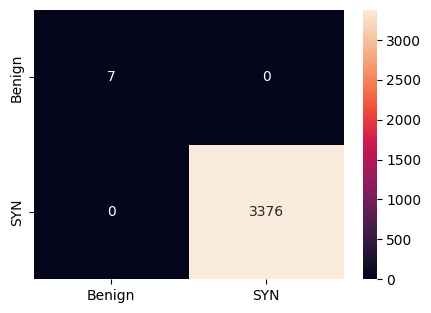





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  DT    1        1       1      1      1      1      1        0.053     0
 1  SYN           0    2     0  DT    0.999    0.75    1      0.75   0.833  0.666  0.75     0.032     0
 2  SYN           0    3     0  DT    1        1       1      1      1      1      1        0.048     0
 3  SYN           0    4     0  DT    1        1       1      1      1      1      1        0.063     0
 4  SYN           0    5     0  DT    0.999    0.917   0.954  0.917  0.935  0.869  0.917    0.031     0
 5  SYN           0    1     1  DT    1        1       1      1      1      1      1        0.048     0
 6  SYN           0    2     1  DT    1        1       1      1      1      1      1        0.056     0
 7  SYN           0    3     1  DT    1        1    

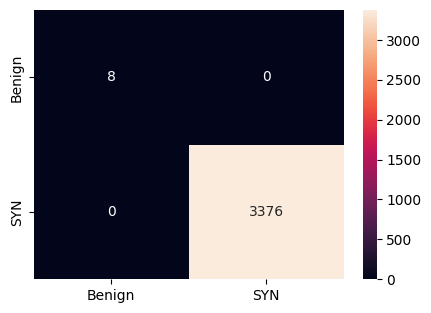





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  RF    1        1           1  1      1      1      1        0.923     0.027
 1  SYN           0    2     0  RF    1        1           1  1      1      1      1        0.823     0.031
 2  SYN           0    3     0  RF    1        1           1  1      1      1      1        0.922     0.027
 3  SYN           0    4     0  RF    1        1           1  1      1      1      1        1         0.013
 4  SYN           0    5     0  RF    1        0.944       1  0.944  0.971  0.941  0.944    0.783     0.032
 5  SYN           0    1     1  RF    1        1           1  1      1      1      1        0.926     0.031
 6  SYN           0    2     1  RF    1        1           1  1      1      1      1        0.996     0.032
 7  SYN           0    3

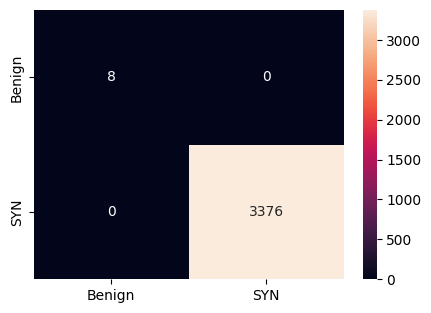





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  KNN   1        1       1      1      1      1      1        0         0.583
 1  SYN           0    2     0  KNN   0.999    0.786   1      0.786  0.863  0.727  0.786    0         0.473
 2  SYN           0    3     0  KNN   0.999    0.889   1      0.889  0.937  0.875  0.889    0         0.487
 3  SYN           0    4     0  KNN   0.999    0.818   0.999  0.818  0.889  0.777  0.818    0         0.392
 4  SYN           0    5     0  KNN   1        0.929   1      0.929  0.961  0.923  0.929    0         0.551
 5  SYN           0    1     1  KNN   1        0.917   1      0.917  0.954  0.909  0.917    0.009     0.394
 6  SYN           0    2     1  KNN   1        0.944   1      0.944  0.971  0.941  0.944    0         0.44
 7  SYN           0    3 

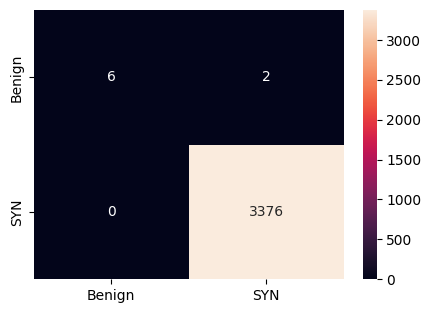





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  NB    0.996    0.998   0.65   0.998  0.73   0.46   0.998    0         0.016
 1  SYN           0    2     0  NB    0.998    0.999   0.767  0.999  0.847  0.695  0.999    0.016     0
 2  SYN           0    3     0  NB    0.995    0.776   0.638  0.776  0.684  0.368  0.776    0         0.016
 3  SYN           0    4     0  NB    0.996    0.898   0.69   0.898  0.757  0.514  0.898    0.02      0
 4  SYN           0    5     0  NB    0.995    0.887   0.666  0.887  0.732  0.465  0.887    0         0.016
 5  SYN           0    1     1  NB    0.996    0.845   0.736  0.845  0.78   0.56   0.845    0         0.016
 6  SYN           0    2     1  NB    0.996    0.998   0.69   0.998  0.775  0.55   0.998    0         0.016
 7  SYN           0    3     1  

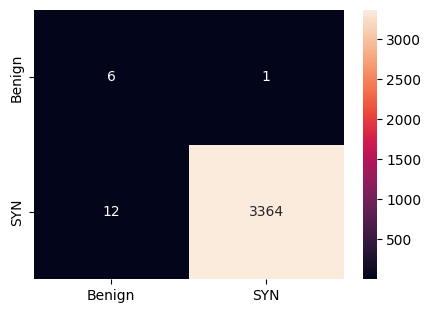





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  XGB   1        0.95        1  0.95   0.974  0.947  0.95     0.896     0.016
 1  SYN           0    2     0  XGB   1        1           1  1      1      1      1        0.817     0.016
 2  SYN           0    3     0  XGB   1        1           1  1      1      1      1        0.677     0.013
 3  SYN           0    4     0  XGB   1        0.958       1  0.958  0.978  0.956  0.958    0.612     0.012
 4  SYN           0    5     0  XGB   1        0.95        1  0.95   0.974  0.947  0.95     0.673     0.011
 5  SYN           0    1     1  XGB   0.999    0.889       1  0.889  0.937  0.875  0.889    0.626     0.018
 6  SYN           0    2     1  XGB   1        1           1  1      1      1      1        0.608     0.01
 7  SYN           0    3 

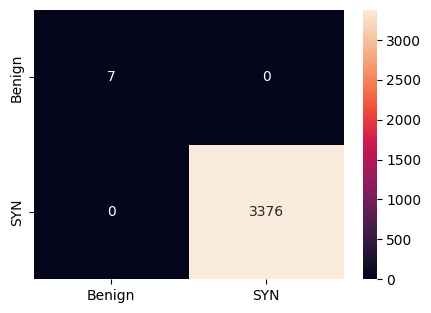





./csvs\mirai-httpflooding-4-dec.pcap_Flow.csv
['Dst Port', 'Flow Duration', 'Flow IAT Max', 'Fwd IAT Tot', 'FIN Flag Cnt', 'SYN Flag Cnt', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  LR    0.948    0.935   0.961  0.935  0.945  0.89   0.935    0.016     0
 1  HTTP          0    2     0  LR    0.943    0.924   0.956  0.924  0.937  0.873  0.924    0.031     0
 2  HTTP          0    3     0  LR    0.935    0.912   0.951  0.912  0.927  0.854  0.912    0.016     0
 3  HTTP          0    4     0  LR    0.924    0.901   0.945  0.901  0.916  0.833  0.901    0         0.016
 4  HTTP          0    5     0  LR    0.948    0.943   0.957  0.943  0.947  0.895  0.943    0.019     0
 5  HTTP          0    1     1  LR    0.921    0.913   0.934  0.913  0.919  0.838  0.913    0.024     0
 6  

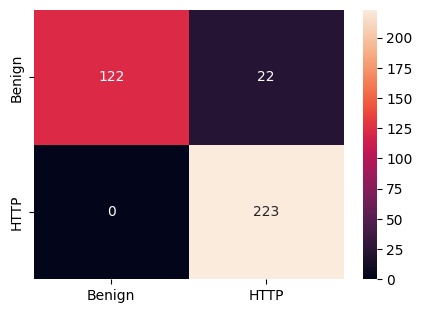





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  DT    0.97     0.967   0.97   0.967  0.969  0.937  0.967    0.005         0
 1  HTTP          0    2     0  DT    0.967    0.962   0.968  0.962  0.965  0.929  0.962    0             0
 2  HTTP          0    3     0  DT    0.948    0.947   0.943  0.947  0.945  0.889  0.947    0.006         0
 3  HTTP          0    4     0  DT    0.959    0.954   0.96   0.954  0.957  0.913  0.954    0.006         0
 4  HTTP          0    5     0  DT    0.97     0.968   0.971  0.968  0.97   0.939  0.968    0.004         0
 5  HTTP          0    1     1  DT    0.962    0.962   0.958  0.962  0.96   0.92   0.962    0             0
 6  HTTP          0    2     1  DT    0.965    0.962   0.963  0.962  0.963  0.925  0.962    0.016         0
 7  HTTP          0    3

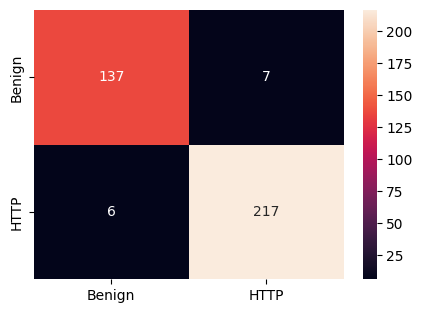





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  RF    0.973    0.969   0.972  0.969  0.971  0.942  0.969    0.056     0
 1  HTTP          0    2     0  RF    0.973    0.969   0.972  0.969  0.971  0.942  0.969    0.047     0
 2  HTTP          0    3     0  RF    0.959    0.956   0.959  0.956  0.957  0.914  0.956    0.047     0.016
 3  HTTP          0    4     0  RF    0.973    0.973   0.971  0.973  0.972  0.944  0.973    0.047     0
 4  HTTP          0    5     0  RF    0.976    0.973   0.977  0.973  0.975  0.95   0.973    0.047     0
 5  HTTP          0    1     1  RF    0.973    0.973   0.971  0.973  0.972  0.944  0.973    0.047     0
 6  HTTP          0    2     1  RF    0.978    0.974   0.981  0.974  0.977  0.954  0.974    0.047     0
 7  HTTP          0    3     1  RF    0.976    0

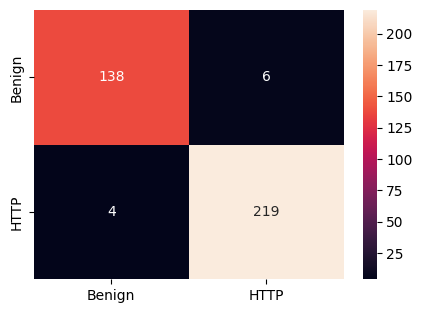





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  KNN   0.897    0.884   0.896  0.884  0.889  0.779  0.884    0         0.047
 1  HTTP          0    2     0  KNN   0.916    0.909   0.914  0.909  0.912  0.823  0.909    0.016     0.031
 2  HTTP          0    3     0  KNN   0.913    0.9     0.921  0.9    0.908  0.816  0.9      0         0.032
 3  HTTP          0    4     0  KNN   0.883    0.867   0.887  0.867  0.874  0.749  0.867    0         0.035
 4  HTTP          0    5     0  KNN   0.878    0.865   0.875  0.865  0.869  0.738  0.865    0.001     0.035
 5  HTTP          0    1     1  KNN   0.897    0.884   0.896  0.884  0.889  0.779  0.884    0.001     0.031
 6  HTTP          0    2     1  KNN   0.916    0.909   0.914  0.909  0.912  0.823  0.909    0         0.031
 7  HTTP          0    3

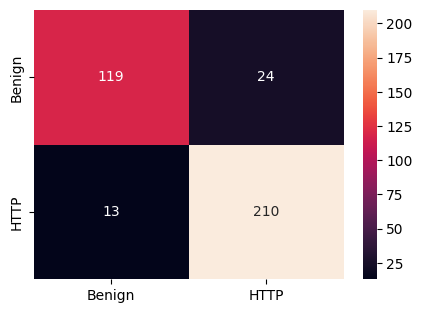





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  NB    0.829    0.796   0.882  0.796  0.808  0.628  0.796    0.001     0.001
 1  HTTP          0    2     0  NB    0.842    0.804   0.888  0.804  0.82   0.648  0.804    0.002     0
 2  HTTP          0    3     0  NB    0.807    0.753   0.869  0.753  0.768  0.554  0.753    0.002     0
 3  HTTP          0    4     0  NB    0.842    0.79    0.885  0.79   0.811  0.631  0.79     0         0
 4  HTTP          0    5     0  NB    0.834    0.796   0.871  0.796  0.811  0.63   0.796    0         0
 5  HTTP          0    1     1  NB    0.802    0.766   0.85   0.766  0.776  0.566  0.766    0.002     0
 6  HTTP          0    2     1  NB    0.848    0.803   0.892  0.803  0.822  0.652  0.803    0.002     0
 7  HTTP          0    3     1  NB    0.818    0

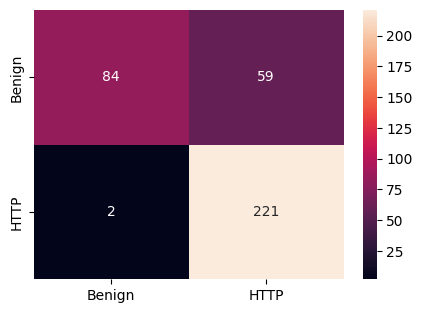





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  XGB   0.965    0.955   0.972  0.955  0.962  0.925  0.955    1.91      0.009
 1  HTTP          0    2     0  XGB   0.976    0.972   0.977  0.972  0.974  0.949  0.972    1.75      0
 2  HTTP          0    3     0  XGB   0.973    0.971   0.971  0.971  0.971  0.942  0.971    1.777     0.004
 3  HTTP          0    4     0  XGB   0.981    0.98    0.979  0.98   0.98   0.96   0.98     1.792     0.006
 4  HTTP          0    5     0  XGB   0.965    0.964   0.963  0.964  0.963  0.927  0.964    1.869     0.007
 5  HTTP          0    1     1  XGB   0.965    0.955   0.969  0.955  0.961  0.923  0.955    1.844     0.009
 6  HTTP          0    2     1  XGB   0.973    0.969   0.975  0.969  0.972  0.944  0.969    1.809     0.019
 7  HTTP          0    3    

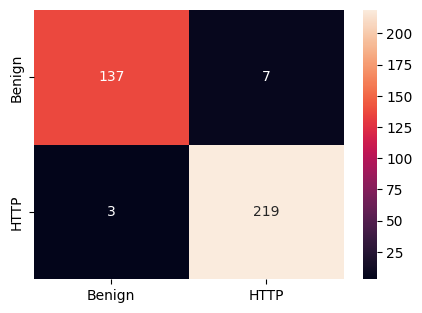





./csvs\mirai-ackflooding-4-dec.pcap_Flow.csv
['TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Flow Byts/s', 'Bwd IAT Std', 'Pkt Len Max', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  LR    0.915    0.926   0.917  0.926  0.914  0.83   0.926    0.031     0
 1  ACK           0    2     0  LR    0.873    0.892   0.883  0.892  0.873  0.751  0.892    0.047     0
 2  ACK           0    3     0  LR    0.882    0.901   0.886  0.901  0.881  0.765  0.901    0.031     0.016
 3  ACK           0    4     0  LR    0.898    0.911   0.904  0.911  0.898  0.798  0.911    0.041     0
 4  ACK           0    5     0 

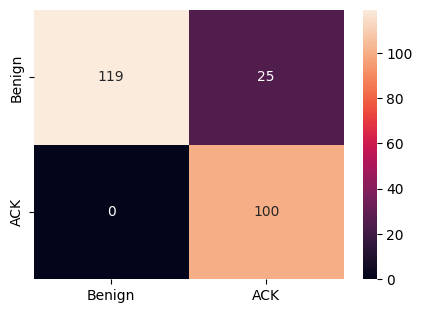





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  DT    0.874    0.89    0.886  0.89   0.874  0.752  0.89     0.001     0.001
 1  ACK           0    2     0  DT    0.906    0.912   0.917  0.912  0.906  0.814  0.912    0         0
 2  ACK           0    3     0  DT    0.873    0.903   0.866  0.903  0.869  0.743  0.903    0         0
 3  ACK           0    4     0  DT    0.922    0.937   0.917  0.937  0.921  0.842  0.937    0         0
 4  ACK           0    5     0  DT    0.89     0.905   0.896  0.905  0.89   0.782  0.905    0         0
 5  ACK           0    1     1  DT    0.902    0.917   0.905  0.917  0.902  0.806  0.917    0         0
 6  ACK           0    2     1  DT    0.89     0.907   0.894  0.907  0.889  0.781  0.907    0         0
 7  ACK           0    3     1  DT    0.89     0

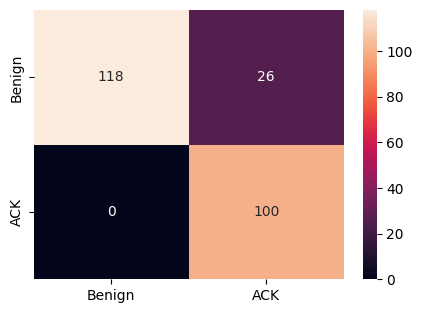





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  RF    0.894    0.91    0.898  0.91   0.894  0.79   0.91     0.321     0.031
 1  ACK           0    2     0  RF    0.898    0.913   0.902  0.913  0.898  0.797  0.913    0.337     0.031
 2  ACK           0    3     0  RF    0.89     0.905   0.896  0.905  0.89   0.782  0.905    0.336     0.016
 3  ACK           0    4     0  RF    0.89     0.915   0.882  0.915  0.886  0.775  0.915    0.322     0.016
 4  ACK           0    5     0  RF    0.898    0.907   0.907  0.907  0.898  0.798  0.907    0.31      0.033
 5  ACK           0    1     1  RF    0.907    0.917   0.912  0.917  0.906  0.814  0.917    0.332     0.032
 6  ACK           0    2     1  RF    0.882    0.908   0.875  0.908  0.878  0.76   0.908    0.326     0.016
 7  ACK           0    3

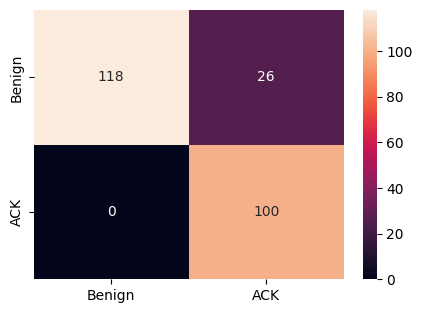





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ACK           0    1     0  KNN   0.553    0.5     0.276  0.5    0.356   0      0.5      0         0
 1  ACK           0    2     0  KNN   0.588    0.497   0.295  0.497  0.37   -0.008  0.497    0.015     0.009
 2  ACK           0    3     0  KNN   0.604    0.5     0.302  0.5    0.377   0      0.5      0.001     0.009
 3  ACK           0    4     0  KNN   0.612    0.497   0.307  0.497  0.38   -0.008  0.497    0         0.012
 4  ACK           0    5     0  KNN   0.58     0.497   0.291  0.497  0.367  -0.008  0.497    0.002     0
 5  ACK           0    1     1  KNN   0.598    0.497   0.3    0.497  0.374  -0.008  0.497    0         0.016
 6  ACK           0    2     1  KNN   0.616    0.5     0.308  0.5    0.381   0      0.5      0         0.016
 7  ACK           0    

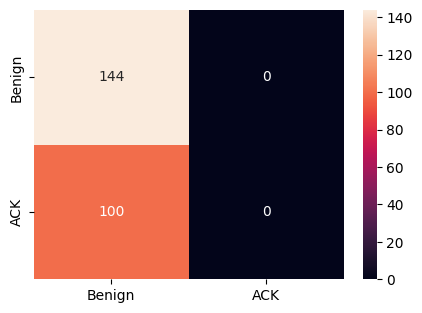





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  NB    0.772    0.806   0.823  0.806  0.772  0.566  0.806    0         0
 1  ACK           0    2     0  NB    0.833    0.855   0.859  0.855  0.833  0.674  0.855    0         0
 2  ACK           0    3     0  NB    0.829    0.859   0.848  0.859  0.828  0.666  0.859    0.011     0
 3  ACK           0    4     0  NB    0.792    0.823   0.832  0.823  0.792  0.601  0.823    0         0
 4  ACK           0    5     0  NB    0.771    0.807   0.821  0.807  0.771  0.565  0.807    0         0
 5  ACK           0    1     1  NB    0.785    0.826   0.82   0.826  0.784  0.588  0.826    0         0
 6  ACK           0    2     1  NB    0.841    0.86    0.866  0.86   0.841  0.689  0.86     0         0
 7  ACK           0    3     1  NB    0.788    0.816

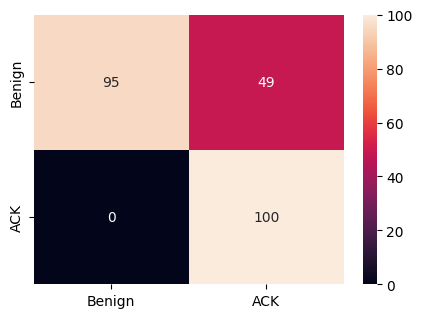





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  XGB   0.894    0.919   0.884  0.919  0.89   0.783  0.919    0.937     0
 1  ACK           0    2     0  XGB   0.849    0.872   0.866  0.872  0.849  0.705  0.872    1.248     0
 2  ACK           0    3     0  XGB   0.939    0.945   0.94   0.945  0.939  0.878  0.945    0.939     0
 3  ACK           0    4     0  XGB   0.882    0.896   0.892  0.896  0.882  0.766  0.896    0.968     0
 4  ACK           0    5     0  XGB   0.906    0.92    0.908  0.92   0.906  0.813  0.92     0.867     0
 5  ACK           0    1     1  XGB   0.874    0.9     0.873  0.9    0.872  0.747  0.9      0.944     0
 6  ACK           0    2     1  XGB   0.902    0.912   0.909  0.912  0.902  0.806  0.912    0.89      0.003
 7  ACK           0    3     1  XGB   0.902    0

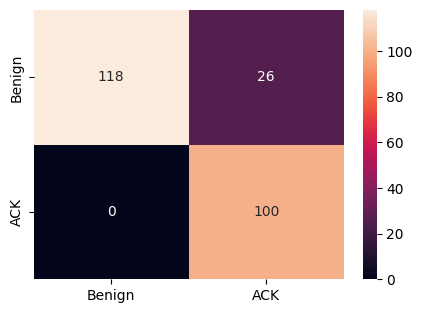





./csvs\mirai-udpflooding-4-dec.pcap_Flow.csv
['Src Port', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Pkt Len Max', 'Pkt Size Avg', 'Subflow Bwd Byts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  LR    1        1       1      1      1      1      1        0.049         0
 1  UDP           0    2     0  LR    1        1       1      1      1      1      1        0.045         0
 2  UDP           0    3     0  LR    0.993    0.997   0.875  0.997  0.927  0.854  0.997    0.037         0
 3  UDP           0    4     0  LR    0.993    0.996   0.929  0.996  0.96   0.92   0.996    0.037         0
 4  UDP           0    5     0  LR    1        1       1      1      1      1

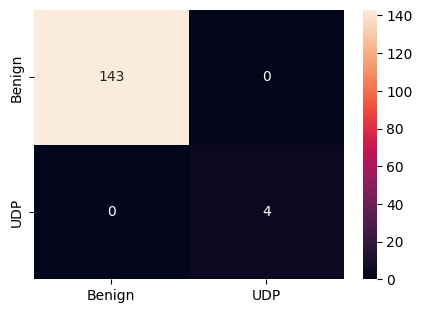





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  DT        1        1       1      1     1      1      1    0.016         0
 1  UDP           0    2     0  DT        1        1       1      1     1      1      1    0.016         0
 2  UDP           0    3     0  DT        1        1       1      1     1      1      1    0.016         0
 3  UDP           0    4     0  DT        1        1       1      1     1      1      1    0.001         0
 4  UDP           0    5     0  DT        1        1       1      1     1      1      1    0.001         0
 5  UDP           0    1     1  DT        1        1       1      1     1      1      1    0.002         0
 6  UDP           0    2     1  DT        1        1       1      1     1      1      1    0             0
 7  UDP           0    3     1  D

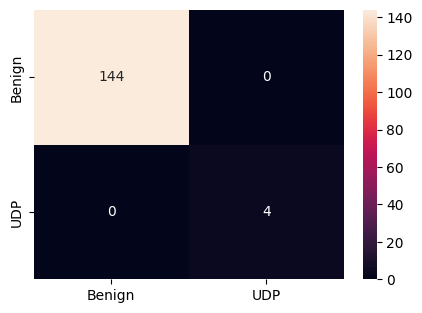





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  RF        1        1       1      1     1      1      1    0.01      0.001
 1  UDP           0    2     0  RF        1        1       1      1     1      1      1    0.012     0.002
 2  UDP           0    3     0  RF        1        1       1      1     1      1      1    0.013     0.002
 3  UDP           0    4     0  RF        1        1       1      1     1      1      1    0.013     0.002
 4  UDP           0    5     0  RF        1        1       1      1     1      1      1    0.013     0.002
 5  UDP           0    1     1  RF        1        1       1      1     1      1      1    0.012     0.002
 6  UDP           0    2     1  RF        1        1       1      1     1      1      1    0.011     0.002
 7  UDP           0    3     1  R

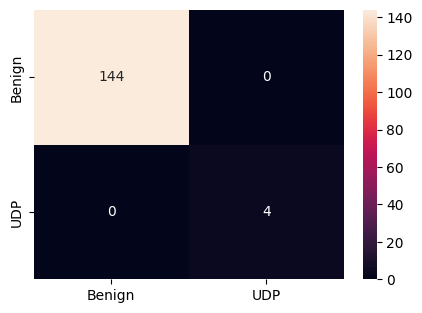





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  KNN   0.993    0.997   0.833  0.997  0.898  0.797  0.997    0.001     0.002
 1  UDP           0    2     0  KNN   0.987    0.993   0.875  0.993  0.925  0.85   0.993    0.002     0.002
 2  UDP           0    3     0  KNN   0.993    0.997   0.833  0.997  0.898  0.797  0.997    0.001     0.003
 3  UDP           0    4     0  KNN   0.993    0.997   0.875  0.997  0.927  0.854  0.997    0.011     0.002
 4  UDP           0    5     0  KNN   0.993    0.996   0.938  0.996  0.965  0.93   0.996    0.001     0.002
 5  UDP           0    1     1  KNN   1        1       1      1      1      1      1        0         0
 6  UDP           0    2     1  KNN   0.993    0.997   0.875  0.997  0.927  0.854  0.997    0         0.007
 7  UDP           0    3    

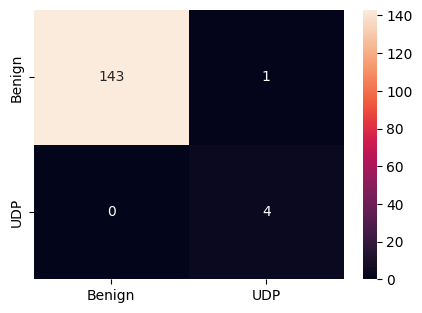





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  NB    0.859    0.928   0.562  0.928  0.572  0.193  0.928    0.001     0
 1  UDP           0    2     0  NB    0.879    0.938   0.571  0.938  0.592  0.223  0.938    0         0
 2  UDP           0    3     0  NB    0.919    0.957   0.7    0.957  0.763  0.536  0.957    0.001     0.001
 3  UDP           0    4     0  NB    0.905    0.952   0.562  0.952  0.586  0.203  0.952    0.001     0
 4  UDP           0    5     0  NB    0.865    0.931   0.583  0.931  0.606  0.251  0.931    0.001     0
 5  UDP           0    1     1  NB    0.846    0.922   0.54   0.922  0.532  0.126  0.922    0.001     0.001
 6  UDP           0    2     1  NB    0.893    0.944   0.636  0.944  0.685  0.39   0.944    0.002     0
 7  UDP           0    3     1  NB    0.919 

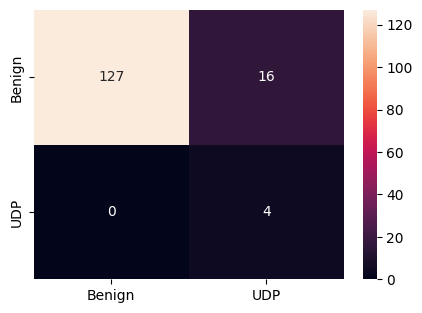





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  XGB   1        1       1      1      1      1      1        0.858     0
 1  UDP           0    2     0  XGB   1        1       1      1      1      1      1        0.357     0
 2  UDP           0    3     0  XGB   1        1       1      1      1      1      1        0.255     0.015
 3  UDP           0    4     0  XGB   1        1       1      1      1      1      1        0.41      0.003
 4  UDP           0    5     0  XGB   0.993    0.997   0.9    0.997  0.943  0.885  0.997    0.427     0
 5  UDP           0    1     1  XGB   0.993    0.997   0.929  0.997  0.96   0.92   0.997    0.404     0.002
 6  UDP           0    2     1  XGB   1        1       1      1      1      1      1        0.341     0
 7  UDP           0    3     1  XGB   1 

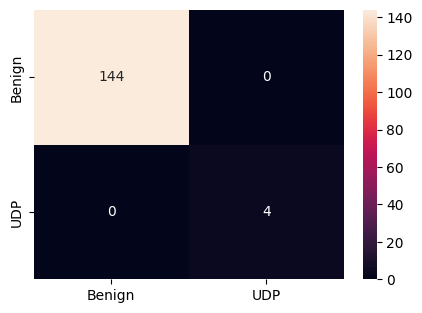





./csvs\mitm-arpspoofing-6-dec.pcap_Flow.csv
['Src Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Std', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Active Min', 'Idle Mean', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  LR    0.644    0.635   0.637  0.635  0.636  0.272  0.635    1.4

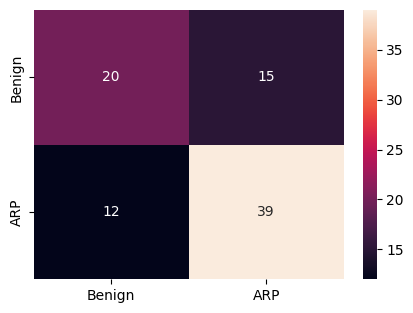





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  DT    0.744    0.75    0.74   0.75   0.741  0.484  0.75     0.008     0
 1  ARP           0    2     0  DT    0.6      0.587   0.595  0.587  0.583  0.177  0.587    0.007     0
 2  ARP           0    3     0  DT    0.64     0.642   0.629  0.642  0.627  0.263  0.642    0.008     0
 3  ARP           0    4     0  DT    0.753    0.742   0.765  0.742  0.743  0.494  0.742    0.008     0
 4  ARP           0    5     0  DT    0.674    0.636   0.657  0.636  0.638  0.285  0.636    0.007     0
 5  ARP           0    1     1  DT    0.744    0.717   0.773  0.717  0.719  0.455  0.717    0.01      0.001
 6  ARP           0    2     1  DT    0.689    0.689   0.675  0.689  0.676  0.357  0.689    0.006     0.001
 7  ARP           0    3     1  DT    0.573 

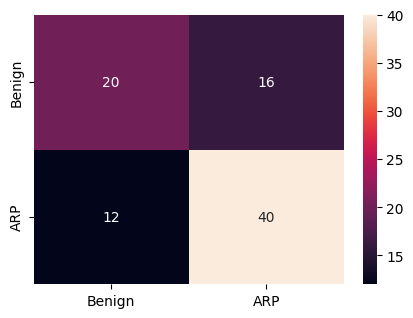





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  RF    0.7      0.657   0.699  0.657  0.66   0.335  0.657    0.089     0.006
 1  ARP           0    2     0  RF    0.667    0.667   0.67   0.667  0.665  0.333  0.667    0.104     0.012
 2  ARP           0    3     0  RF    0.742    0.674   0.716  0.674  0.684  0.376  0.674    0.085     0.01
 3  ARP           0    4     0  RF    0.73     0.711   0.726  0.711  0.714  0.432  0.711    0.076     0.006
 4  ARP           0    5     0  RF    0.674    0.651   0.66   0.651  0.653  0.308  0.651    0.079     0.005
 5  ARP           0    1     1  RF    0.656    0.638   0.645  0.638  0.639  0.281  0.638    0.069     0.008
 6  ARP           0    2     1  RF    0.733    0.716   0.73   0.716  0.719  0.442  0.716    0.078     0.006
 7  ARP           0    3 

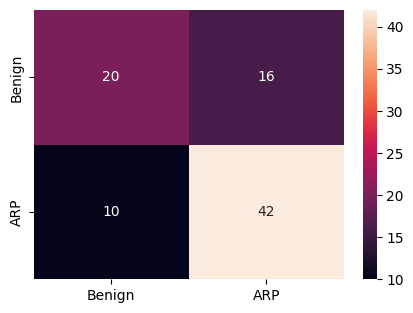





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  KNN   0.756    0.736   0.765  0.736  0.74   0.487  0.736    0.002     0.001
 1  ARP           0    2     0  KNN   0.656    0.602   0.647  0.602  0.594  0.221  0.602    0.001     0.002
 2  ARP           0    3     0  KNN   0.674    0.651   0.657  0.651  0.653  0.307  0.651    0.003     0.002
 3  ARP           0    4     0  KNN   0.618    0.575   0.588  0.575  0.573  0.157  0.575    0.001     0.002
 4  ARP           0    5     0  KNN   0.708    0.686   0.717  0.686  0.687  0.386  0.686    0.001     0.002
 5  ARP           0    1     1  KNN   0.622    0.588   0.599  0.588  0.588  0.183  0.588    0.001     0.002
 6  ARP           0    2     1  KNN   0.644    0.618   0.691  0.618  0.593  0.247  0.618    0.002     0.002
 7  ARP           0    3

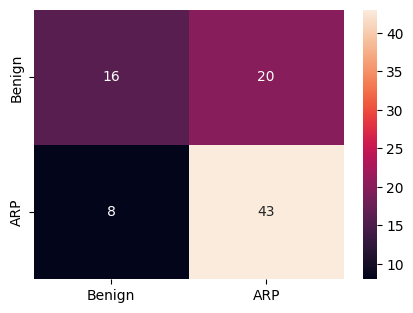





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP           0    1     0  NB    0.6      0.534   0.577  0.534  0.489   0.076  0.534    0         0.002
 1  ARP           0    2     0  NB    0.578    0.519   0.533  0.519  0.486   0.042  0.519    0.001     0.001
 2  ARP           0    3     0  NB    0.551    0.505   0.526  0.505  0.396   0.01   0.505    0         0.001
 3  ARP           0    4     0  NB    0.618    0.51    0.523  0.51   0.47    0.023  0.51     0.001     0.001
 4  ARP           0    5     0  NB    0.551    0.497   0.494  0.497  0.444  -0.006  0.497    0.001     0.001
 5  ARP           0    1     1  NB    0.578    0.53    0.619  0.53   0.445   0.066  0.53     0.001     0.001
 6  ARP           0    2     1  NB    0.556    0.481   0.467  0.481  0.446  -0.043  0.481    0.002     0
 7  ARP           0

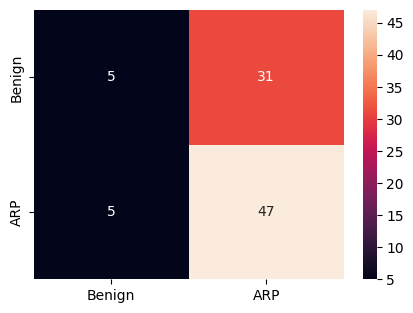





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  XGB   0.744    0.727   0.775  0.727  0.727  0.469  0.727    1.492     0.005
 1  ARP           0    2     0  XGB   0.678    0.657   0.666  0.657  0.659  0.321  0.657    1.082     0.004
 2  ARP           0    3     0  XGB   0.753    0.739   0.764  0.739  0.741  0.489  0.739    1.142     0.003
 3  ARP           0    4     0  XGB   0.742    0.714   0.723  0.714  0.717  0.436  0.714    1.275     0.003
 4  ARP           0    5     0  XGB   0.663    0.608   0.631  0.608  0.609  0.23   0.608    1.134     0.003
 5  ARP           0    1     1  XGB   0.656    0.63    0.642  0.63   0.631  0.268  0.63     1.384     0.006
 6  ARP           0    2     1  XGB   0.733    0.716   0.735  0.716  0.719  0.444  0.716    1.832     0.005
 7  ARP           0    3

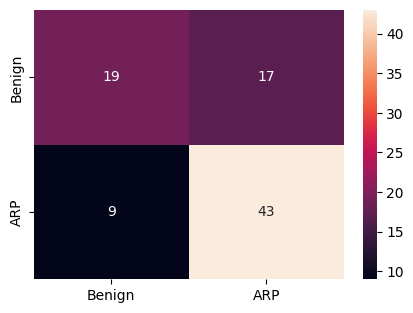





./csvs\scan-hostport-3-dec.pcap_Flow.csv
['Tot Fwd Pkts', 'TotLen Fwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow IAT Std', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Header Len', 'Fwd Pkts/s', 'Pkt Len Var', 'SYN Flag Cnt', 'Fwd Seg Size Avg', 'Subflow Bwd Pkts', 'Init Bwd Win Byts', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  LR    1        1       1      1      1      1      1        0.005     0
 1  SP            0    2     0  LR    1        1       1      1      1      1      1        0.003     0
 2  SP            0    3     0  LR    1        1       1      1      1      1    

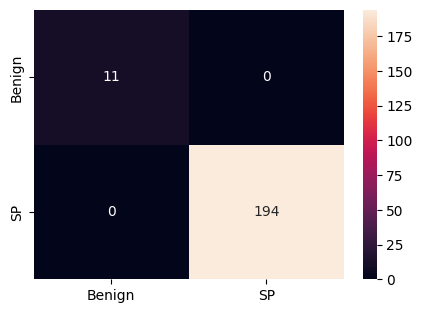





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  DT    1        1       1      1      1      1      1        0.002     0.001
 1  SP            0    2     0  DT    0.995    0.967   0.997  0.967  0.981  0.963  0.967    0.001     0
 2  SP            0    3     0  DT    1        1       1      1      1      1      1        0.001     0.001
 3  SP            0    4     0  DT    1        1       1      1      1      1      1        0.001     0.001
 4  SP            0    5     0  DT    0.995    0.938   0.997  0.938  0.965  0.931  0.938    0.001     0
 5  SP            0    1     1  DT    1        1       1      1      1      1      1        0         0
 6  SP            0    2     1  DT    1        1       1      1      1      1      1        0.001     0
 7  SP            0    3     1  DT    1 

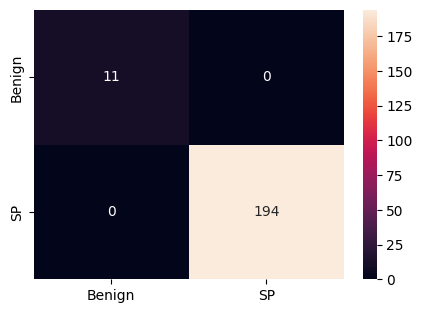





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SP            0    1     0  RF        1        1       1      1     1      1      1    0.071     0.006
 1  SP            0    2     0  RF        1        1       1      1     1      1      1    0.044     0.004
 2  SP            0    3     0  RF        1        1       1      1     1      1      1    0.044     0.006
 3  SP            0    4     0  RF        1        1       1      1     1      1      1    0.046     0.007
 4  SP            0    5     0  RF        1        1       1      1     1      1      1    0.044     0.004
 5  SP            0    1     1  RF        1        1       1      1     1      1      1    0.06      0.01
 6  SP            0    2     1  RF        1        1       1      1     1      1      1    0.049     0.005
 7  SP            0    3     1  RF

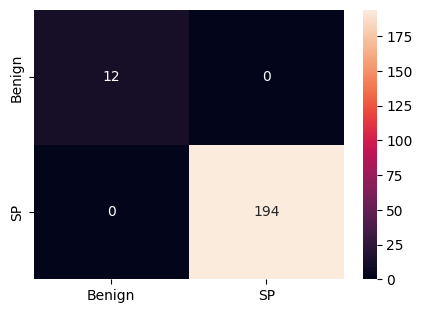





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  KNN   0.99     0.889   0.995  0.889  0.935  0.87   0.889    0.004     0.016
 1  SP            0    2     0  KNN   0.995    0.971   0.997  0.971  0.984  0.967  0.971    0.002     0.011
 2  SP            0    3     0  KNN   0.981    0.882   0.99   0.882  0.928  0.856  0.882    0.004     0.012
 3  SP            0    4     0  KNN   0.995    0.938   0.997  0.938  0.965  0.931  0.938    0.003     0.011
 4  SP            0    5     0  KNN   1        1       1      1      1      1      1        0.003     0.009
 5  SP            0    1     1  KNN   0.99     0.909   0.995  0.909  0.947  0.895  0.909    0.003     0.011
 6  SP            0    2     1  KNN   1        1       1      1      1      1      1        0.002     0.009
 7  SP            0    3

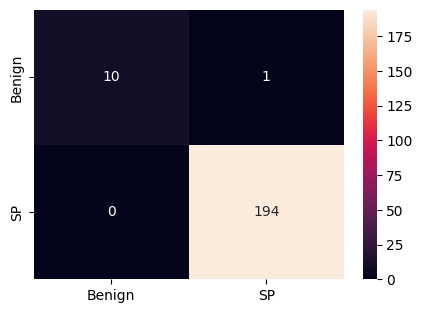





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  NB    0.99     0.941   0.995  0.941  0.966  0.932  0.941    0.002     0
 1  SP            0    2     0  NB    0.995    0.971   0.997  0.971  0.984  0.967  0.971    0.002     0
 2  SP            0    3     0  NB    0.995    0.955   0.997  0.955  0.975  0.95   0.955    0.001     0.001
 3  SP            0    4     0  NB    0.99     0.8     0.995  0.8    0.873  0.745  0.8      0.002     0.001
 4  SP            0    5     0  NB    1        1       1      1      1      1      1        0.002     0
 5  SP            0    1     1  NB    0.99     0.917   0.995  0.917  0.952  0.904  0.917    0.001     0
 6  SP            0    2     1  NB    0.986    0.932   0.886  0.932  0.908  0.816  0.932    0         0.001
 7  SP            0    3     1  NB    0.

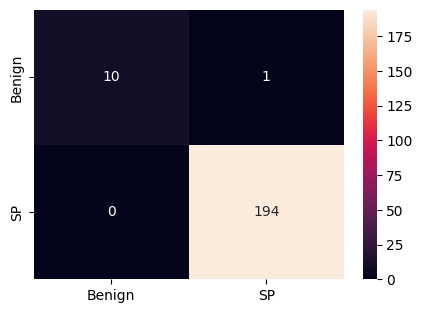





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SP            0    1     0  XGB       1        1       1      1     1      1      1    1.992     0.007
 1  SP            0    2     0  XGB       1        1       1      1     1      1      1    2.625     0.004
 2  SP            0    3     0  XGB       1        1       1      1     1      1      1    1.691     0.005
 3  SP            0    4     0  XGB       1        1       1      1     1      1      1    1.614     0.004
 4  SP            0    5     0  XGB       1        1       1      1     1      1      1    1.472     0.005
 5  SP            0    1     1  XGB       1        1       1      1     1      1      1    1.864     0.005
 6  SP            0    2     1  XGB       1        1       1      1     1      1      1    2.116     0.005
 7  SP            0    3     1  X

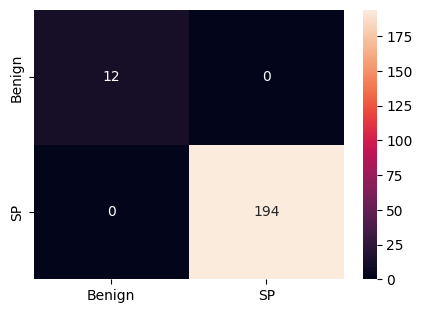





./csvs\mirai-hostbruteforce-5-dec.pcap_Flow.csv
['Tot Bwd Pkts', 'TotLen Fwd Pkts', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Min', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  BF            0    1     0  LR    0.792    0.494   0.4    0.494  0.442  -0.02   0.494    0.007     0
 1  BF            0    2     0  LR    0.888    0.5     0.444  0.5    0.47    0      0.5      0.007     0
 2  BF            0    3     0  LR    0.898    0.5     0.449  0.5    0.473   0      0.5      0.006     0.001
 3  BF            0    4     0  LR    0.802    0.488   0.409  0.488  0.445  -0.038  0.488    0.008     0
 4  BF            0    5     0  LR    0.806    0.485   0.414  0.485  0.446  -0.046  0.485    0.006     0
 5  BF      

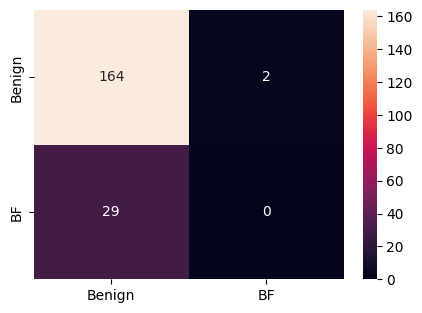





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  DT    0.944    0.905   0.871  0.905  0.887  0.774  0.905    0.005     0
 1  BF            0    2     0  DT    0.944    0.904   0.894  0.904  0.899  0.797  0.904    0.004     0
 2  BF            0    3     0  DT    0.883    0.783   0.855  0.783  0.811  0.623  0.783    0.003     0.001
 3  BF            0    4     0  DT    0.929    0.876   0.803  0.876  0.834  0.669  0.876    0.002     0.002
 4  BF            0    5     0  DT    0.939    0.883   0.86   0.883  0.871  0.742  0.883    0.004     0.001
 5  BF            0    1     1  DT    0.919    0.84    0.889  0.84   0.861  0.722  0.84     0.004     0
 6  BF            0    2     1  DT    0.919    0.854   0.854  0.854  0.854  0.709  0.854    0.003     0
 7  BF            0    3     1  DT    0.

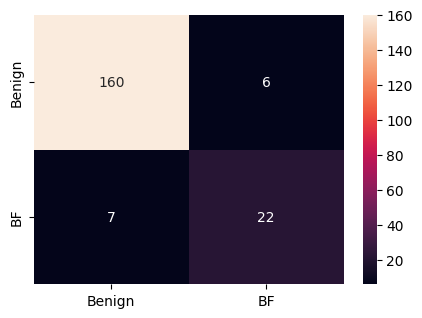





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  RF    0.944    0.882   0.893  0.882  0.887  0.774  0.882    0.307     0.018
 1  BF            0    2     0  RF    0.909    0.804   0.872  0.804  0.832  0.665  0.804    0.3       0.019
 2  BF            0    3     0  RF    0.954    0.876   0.918  0.876  0.895  0.79   0.876    0.299     0.023
 3  BF            0    4     0  RF    0.934    0.848   0.917  0.848  0.877  0.755  0.848    0.295     0.018
 4  BF            0    5     0  RF    0.974    0.929   0.946  0.929  0.937  0.874  0.929    0.289     0.023
 5  BF            0    1     1  RF    0.949    0.847   0.952  0.847  0.889  0.779  0.847    0.318     0.021
 6  BF            0    2     1  RF    0.944    0.875   0.908  0.875  0.89   0.781  0.875    0.28      0.025
 7  BF            0    3

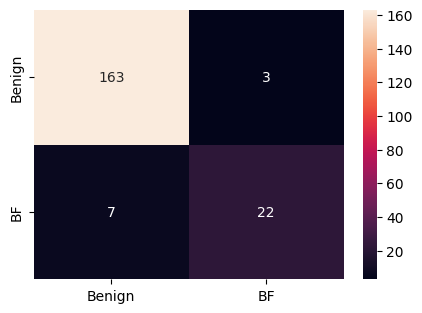





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  KNN   0.873    0.755   0.734  0.755  0.744  0.487  0.755    0.001     0.002
 1  BF            0    2     0  KNN   0.893    0.829   0.773  0.829  0.796  0.594  0.829    0.001     0.002
 2  BF            0    3     0  KNN   0.914    0.781   0.792  0.781  0.787  0.574  0.781    0.002     0.002
 3  BF            0    4     0  KNN   0.888    0.791   0.82   0.791  0.804  0.609  0.791    0.002     0.001
 4  BF            0    5     0  KNN   0.893    0.773   0.845  0.773  0.801  0.604  0.773    0.002     0.003
 5  BF            0    1     1  KNN   0.939    0.867   0.907  0.867  0.885  0.77   0.867    0.001     0.003
 6  BF            0    2     1  KNN   0.853    0.742   0.791  0.742  0.761  0.524  0.742    0.002     0.002
 7  BF            0    3

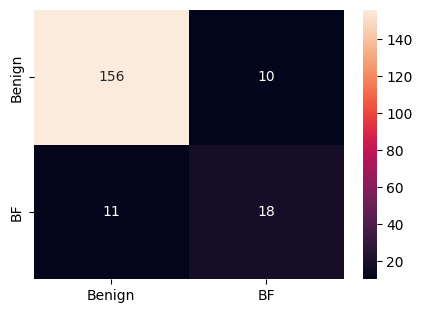





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  BF            0    1     0  NB    0.822    0.525   0.746  0.525  0.502   0.077  0.525    0         0
 1  BF            0    2     0  NB    0.853    0.502   0.504  0.502  0.492   0.005  0.502    0.002     0.001
 2  BF            0    3     0  NB    0.716    0.449   0.39   0.449  0.417  -0.131  0.449    0.002     0
 3  BF            0    4     0  NB    0.827    0.463   0.443  0.463  0.453  -0.089  0.463    0.001     0.001
 4  BF            0    5     0  NB    0.857    0.546   0.732  0.546  0.549   0.139  0.546    0.001     0
 5  BF            0    1     1  NB    0.792    0.494   0.49   0.494  0.486  -0.014  0.494    0.002     0
 6  BF            0    2     1  NB    0.817    0.522   0.662  0.522  0.499   0.066  0.522    0.001     0.001
 7  BF            0    3     1 

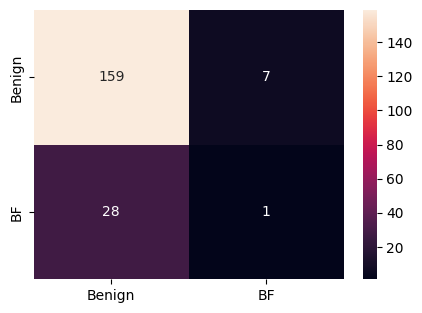





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  XGB   0.959    0.882   0.977  0.882  0.921  0.843  0.882    1.44      0.005
 1  BF            0    2     0  XGB   0.934    0.817   0.923  0.817  0.858  0.718  0.817    1.574     0.005
 2  BF            0    3     0  XGB   0.939    0.887   0.864  0.887  0.875  0.75   0.887    2.379     0.008
 3  BF            0    4     0  XGB   0.959    0.888   0.96   0.888  0.919  0.839  0.888    1.63      0.006
 4  BF            0    5     0  XGB   0.954    0.905   0.892  0.905  0.899  0.797  0.905    1.48      0.006
 5  BF            0    1     1  XGB   0.964    0.964   0.903  0.964  0.93   0.861  0.964    1.536     0.007
 6  BF            0    2     1  XGB   0.939    0.871   0.845  0.871  0.858  0.715  0.871    1.414     0.005
 7  BF            0    3

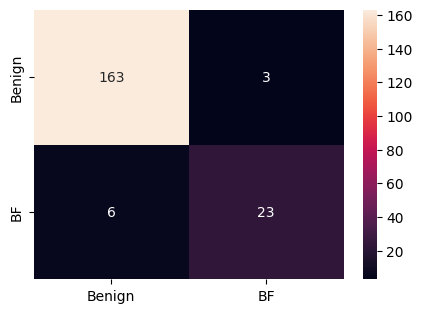

In [18]:
folder("results/cv/")

for file in file_list:
    print(file)
    feature=feature_list[file_list[file]]
    train=file
    test=file
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/cv/{file_list[file]}_VAL_chosed_output_ML_.csv"
    target_names=["Benign",file_list[file]]
    ML_CV(train,test,output_csv,feature,file_list[file],0)   


# SS

In [19]:
file_list={"SYN":[ './csvs\\dos-synflooding-1-dec.pcap_Flow.csv', './csvs\\dos-synflooding-2-dec.pcap_Flow.csv',],
"HTTP":['./csvs\\mirai-httpflooding-4-dec.pcap_Flow.csv', './csvs\\mirai-httpflooding-1-dec.pcap_Flow.csv'],
"ACK":['./csvs\\mirai-ackflooding-4-dec.pcap_Flow.csv','./csvs\\mirai-ackflooding-1-dec.pcap_Flow.csv'],
"UDP":[ './csvs\\mirai-udpflooding-4-dec.pcap_Flow.csv','./csvs\\mirai-udpflooding-1-dec.pcap_Flow.csv'],
"ARP":[ './csvs\\mitm-arpspoofing-6-dec.pcap_Flow.csv', './csvs\\mitm-arpspoofing-4-dec.pcap_Flow.csv'],
"SP":['./csvs\\scan-hostport-3-dec.pcap_Flow.csv','./csvs\\scan-hostport-4-dec.pcap_Flow.csv'],
"BF":[ './csvs\\mirai-hostbruteforce-5-dec.pcap_Flow.csv','./csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv']}

SYN
['Src Port', 'Protocol', 'Flow Duration', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Std', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Fwd Pkts/s', 'Pkt Len Min', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'SYN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Active Mean', 'Active Std', 'Active Max', 'Idle Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  LR    0.998    0.879   0.925  0.879  0.901  0.801  0.879    0.495     0.002
 1  SYN           0    1     1  LR  

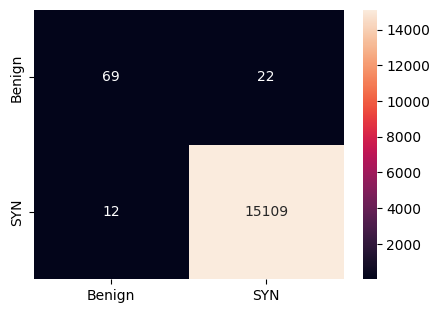





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  DT    1        0.984   1      0.984  0.992  0.983  0.984    0.06      0.004
 1  SYN           0    1     1  DT    1        0.978   1      0.978  0.989  0.977  0.978    0.057     0.003
 2  SYN           0    1     2  DT    1        0.972   0.988  0.972  0.98   0.961  0.972    0.066     0.004
 3  SYN           0    1     3  DT    1        0.989   1      0.989  0.994  0.989  0.989    0.056     0.002
 4  SYN           0    1     4  DT    1        1       0.989  1      0.995  0.989  1        0.066     0.004
 5  SYN           0    1     5  DT    1        0.978   1      0.978  0.989  0.977  0.978    0.059     0.003
 6  SYN           0    1     6  DT    1        1       0.989  1      0.995  0.989  1        0.061     0.004
 7  SYN           0    1

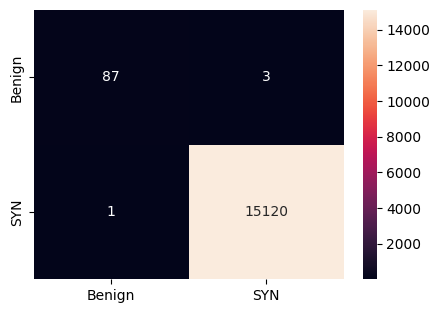





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  RF        1    0.989   0.994  0.989  0.992  0.983  0.989    1.085     0.094
 1  SYN           0    1     1  RF        1    0.994   0.989  0.994  0.992  0.984  0.994    0.995     0.101
 2  SYN           0    1     2  RF        1    0.983   0.994  0.983  0.989  0.978  0.983    1.012     0.099
 3  SYN           0    1     3  RF        1    0.989   0.989  0.989  0.989  0.978  0.989    1.009     0.095
 4  SYN           0    1     4  RF        1    0.994   0.994  0.994  0.994  0.989  0.994    1.106     0.115
 5  SYN           0    1     5  RF        1    0.984   1      0.984  0.992  0.983  0.984    1.077     0.1
 6  SYN           0    1     6  RF        1    0.994   0.994  0.994  0.994  0.989  0.994    0.962     0.093
 7  SYN           0    1  

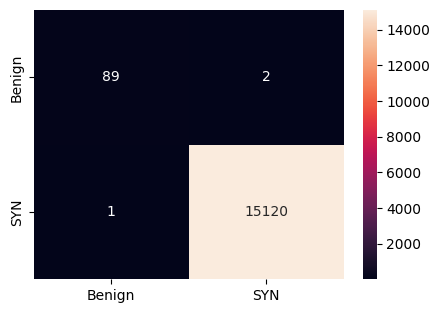





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  KNN   0.998    0.879   0.953  0.879  0.913  0.825  0.879    0.004     1.823
 1  SYN           0    1     1  KNN   0.998    0.879   0.953  0.879  0.913  0.825  0.879    0.005     1.781
 2  SYN           0    1     2  KNN   0.998    0.879   0.953  0.879  0.913  0.825  0.879    0.004     2.215
 3  SYN           0    1     3  KNN   0.998    0.879   0.953  0.879  0.913  0.825  0.879    0.016     1.825
 4  SYN           0    1     4  KNN   0.998    0.879   0.953  0.879  0.913  0.825  0.879    0         1.998
 5  SYN           0    1     5  KNN   0.998    0.879   0.953  0.879  0.913  0.825  0.879    0         1.998
 6  SYN           0    1     6  KNN   0.998    0.879   0.953  0.879  0.913  0.825  0.879    0         1.856
 7  SYN           0    1

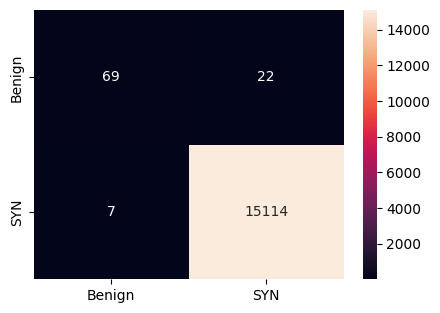





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  NB    0.995    0.899   0.785  0.899  0.832  0.664  0.899    0.016     0.016
 1  SYN           0    1     1  NB    0.995    0.899   0.785  0.899  0.832  0.664  0.899    0.016     0.016
 2  SYN           0    1     2  NB    0.995    0.899   0.785  0.899  0.832  0.664  0.899    0.016     0.016
 3  SYN           0    1     3  NB    0.995    0.899   0.785  0.899  0.832  0.664  0.899    0.016     0.016
 4  SYN           0    1     4  NB    0.995    0.899   0.785  0.899  0.832  0.664  0.899    0.013     0.016
 5  SYN           0    1     5  NB    0.995    0.899   0.785  0.899  0.832  0.664  0.899    0.016     0.016
 6  SYN           0    1     6  NB    0.995    0.899   0.785  0.899  0.832  0.664  0.899    0.001     0.016
 7  SYN           0    1

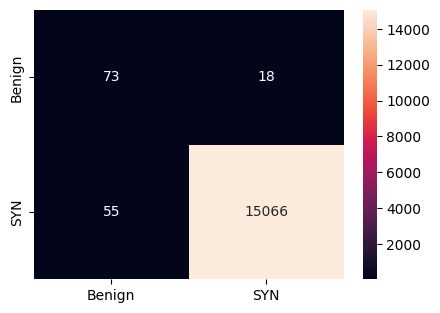





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  XGB       1    0.973       1  0.973  0.986  0.972  0.973    0.802     0.031
 1  SYN           0    1     1  XGB       1    0.973       1  0.973  0.986  0.972  0.973    0.77      0.031
 2  SYN           0    1     2  XGB       1    0.973       1  0.973  0.986  0.972  0.973    0.754     0.032
 3  SYN           0    1     3  XGB       1    0.973       1  0.973  0.986  0.972  0.973    0.755     0.032
 4  SYN           0    1     4  XGB       1    0.973       1  0.973  0.986  0.972  0.973    0.579     0.016
 5  SYN           0    1     5  XGB       1    0.973       1  0.973  0.986  0.972  0.973    0.77      0.032
 6  SYN           0    1     6  XGB       1    0.973       1  0.973  0.986  0.972  0.973    0.755     0.031
 7  SYN           0    1

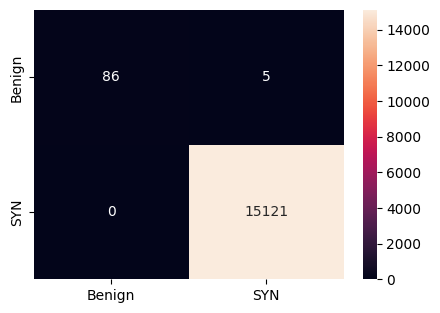





HTTP
['Dst Port', 'Flow Duration', 'Flow IAT Max', 'Fwd IAT Tot', 'FIN Flag Cnt', 'SYN Flag Cnt', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  LR    0.923    0.911    0.94  0.911  0.919  0.839  0.911    0.022         0
 1  HTTP          0    1     1  LR    0.923    0.911    0.94  0.911  0.919  0.839  0.911    0.031         0
 2  HTTP          0    1     2  LR    0.923    0.911    0.94  0.911  0.919  0.839  0.911    0.031         0
 3  HTTP          0    1     3  LR    0.923    0.911    0.94  0.911  0.919  0.839  0.911    0.012         0
 4  HTTP          0    1     4  LR    0.923    0.911    0.94  0.911  0.919  0.839  0.911    0.016         0
 5  HTTP          0    1     5  LR    0.923    0.911    0.94  0.911  0.919  0.839  0.911    0.028         0
 6  HTTP          0    1 

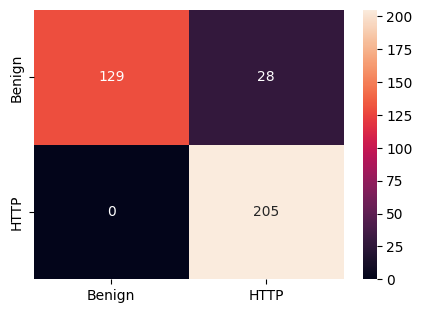





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  DT    0.945    0.947   0.942  0.947  0.944  0.888  0.947    0             0
 1  HTTP          0    1     1  DT    0.925    0.924   0.924  0.924  0.924  0.848  0.924    0             0
 2  HTTP          0    1     2  DT    0.972    0.973   0.971  0.973  0.972  0.944  0.973    0.016         0
 3  HTTP          0    1     3  DT    0.975    0.974   0.976  0.974  0.975  0.949  0.974    0.016         0
 4  HTTP          0    1     4  DT    0.967    0.966   0.967  0.966  0.966  0.932  0.966    0             0
 5  HTTP          0    1     5  DT    0.961    0.961   0.96   0.961  0.961  0.921  0.961    0.004         0
 6  HTTP          0    1     6  DT    0.964    0.965   0.962  0.965  0.964  0.927  0.965    0.004         0
 7  HTTP          0    1

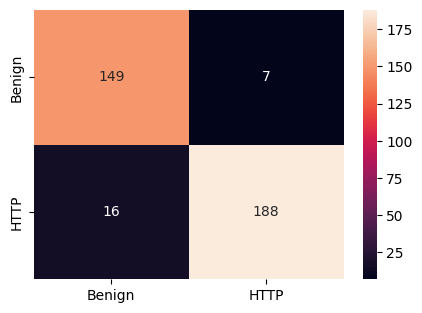





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  RF    0.961    0.963   0.959  0.963  0.961  0.922  0.963    0.063     0.003
 1  HTTP          0    1     1  RF    0.964    0.965   0.962  0.965  0.964  0.927  0.965    0.06      0.004
 2  HTTP          0    1     2  RF    0.961    0.963   0.959  0.963  0.961  0.922  0.963    0.056     0
 3  HTTP          0    1     3  RF    0.961    0.963   0.959  0.963  0.961  0.922  0.963    0.047     0
 4  HTTP          0    1     4  RF    0.961    0.963   0.959  0.963  0.961  0.922  0.963    0.063     0
 5  HTTP          0    1     5  RF    0.964    0.965   0.962  0.965  0.964  0.927  0.965    0.077     0.001
 6  HTTP          0    1     6  RF    0.964    0.965   0.962  0.965  0.964  0.927  0.965    0.058     0.002
 7  HTTP          0    1     7  RF  

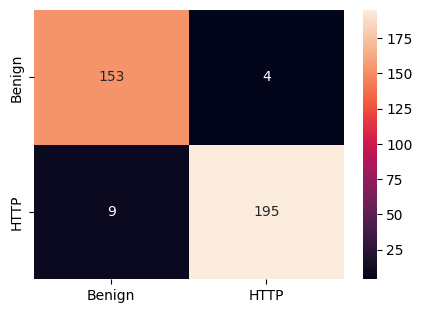





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  HTTP          0    1     0  KNN   0.843    0.842   0.839  0.842  0.84  0.681  0.842    0         0.048
 1  HTTP          0    1     1  KNN   0.843    0.842   0.839  0.842  0.84  0.681  0.842    0         0.042
 2  HTTP          0    1     2  KNN   0.843    0.842   0.839  0.842  0.84  0.681  0.842    0.001     0.037
 3  HTTP          0    1     3  KNN   0.843    0.842   0.839  0.842  0.84  0.681  0.842    0         0.116
 4  HTTP          0    1     4  KNN   0.843    0.842   0.839  0.842  0.84  0.681  0.842    0         0.041
 5  HTTP          0    1     5  KNN   0.843    0.842   0.839  0.842  0.84  0.681  0.842    0         0.024
 6  HTTP          0    1     6  KNN   0.843    0.842   0.839  0.842  0.84  0.681  0.842    0.016     0.032
 7  HTTP          0    1     7  K

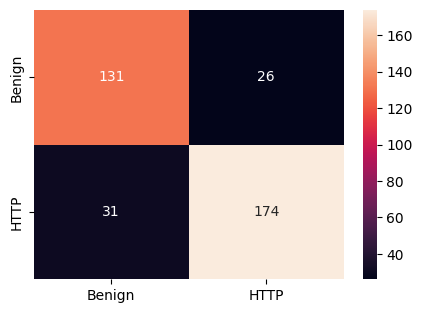





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  NB    0.779    0.745    0.86  0.745  0.747  0.522  0.745    0.001     0
 1  HTTP          0    1     1  NB    0.779    0.745    0.86  0.745  0.747  0.522  0.745    0         0
 2  HTTP          0    1     2  NB    0.779    0.745    0.86  0.745  0.747  0.522  0.745    0         0
 3  HTTP          0    1     3  NB    0.779    0.745    0.86  0.745  0.747  0.522  0.745    0         0
 4  HTTP          0    1     4  NB    0.779    0.745    0.86  0.745  0.747  0.522  0.745    0.002     0
 5  HTTP          0    1     5  NB    0.779    0.745    0.86  0.745  0.747  0.522  0.745    0         0
 6  HTTP          0    1     6  NB    0.779    0.745    0.86  0.745  0.747  0.522  0.745    0         0
 7  HTTP          0    1     7  NB    0.779    0.745

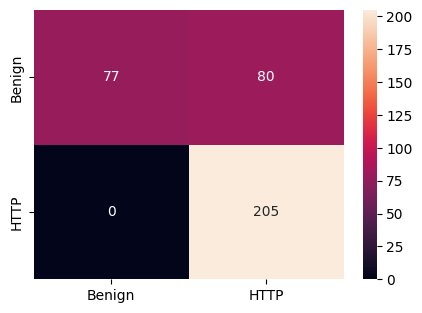





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  XGB   0.942    0.942    0.94  0.942  0.941  0.882  0.942    2.229     0
 1  HTTP          0    1     1  XGB   0.942    0.942    0.94  0.942  0.941  0.882  0.942    2.052     0.006
 2  HTTP          0    1     2  XGB   0.942    0.942    0.94  0.942  0.941  0.882  0.942    1.799     0.005
 3  HTTP          0    1     3  XGB   0.942    0.942    0.94  0.942  0.941  0.882  0.942    2.25      0.047
 4  HTTP          0    1     4  XGB   0.942    0.942    0.94  0.942  0.941  0.882  0.942    2.199     0.016
 5  HTTP          0    1     5  XGB   0.942    0.942    0.94  0.942  0.941  0.882  0.942    2.319     0
 6  HTTP          0    1     6  XGB   0.942    0.942    0.94  0.942  0.941  0.882  0.942    1.86      0.005
 7  HTTP          0    1     7  

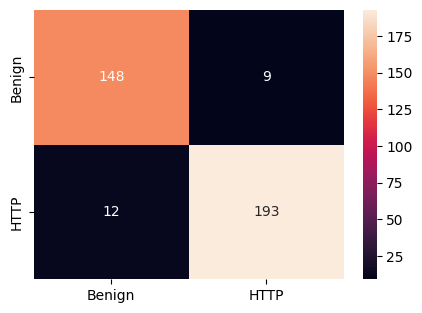





ACK
['TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Flow Byts/s', 'Bwd IAT Std', 'Pkt Len Max', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  LR    0.997     0.94   0.995   0.94  0.966  0.931   0.94    0.045     0.001
 1  ACK           0    1     1  LR    0.997     0.94   0.995   0.94  0.966  0.931   0.94    0.056     0.001
 2  ACK           0    1     2  LR    0.997     0.94   0.995   0.94  0.966  0.931   0.94    0.061     0.001
 3  ACK           0    1     3  LR    0.997     0.94   0.995   0.94  0.966  0.931   0.94    0.057     0.001
 4  ACK           0    1     4  LR    0.997     0.94   0.995

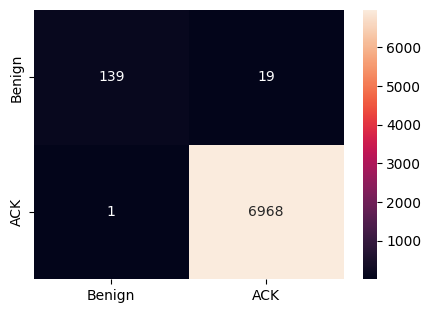





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  DT    0.997    0.94    0.999  0.94   0.967  0.935  0.94     0         0
 1  ACK           0    1     1  DT    0.997    0.94    0.995  0.94   0.966  0.931  0.94     0         0
 2  ACK           0    1     2  DT    0.997    0.94    0.995  0.94   0.966  0.931  0.94     0         0
 3  ACK           0    1     3  DT    0.997    0.94    0.995  0.94   0.966  0.931  0.94     0.001     0.001
 4  ACK           0    1     4  DT    0.997    0.94    0.995  0.94   0.966  0.931  0.94     0.001     0.001
 5  ACK           0    1     5  DT    0.997    0.937   0.995  0.937  0.964  0.928  0.937    0.001     0.001
 6  ACK           0    1     6  DT    0.997    0.94    0.995  0.94   0.966  0.931  0.94     0.001     0.001
 7  ACK           0    1     7  DT  

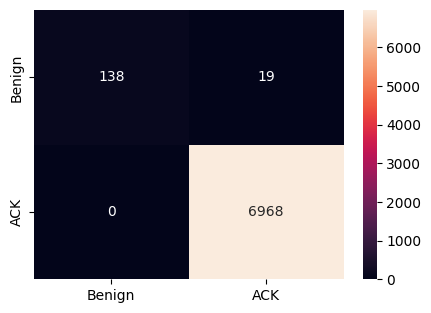





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  RF    0.997     0.94   0.995   0.94  0.966  0.931   0.94    0.32      0.122
 1  ACK           0    1     1  RF    0.997     0.94   0.995   0.94  0.966  0.931   0.94    0.333     0.123
 2  ACK           0    1     2  RF    0.997     0.94   0.995   0.94  0.966  0.931   0.94    0.339     0.101
 3  ACK           0    1     3  RF    0.997     0.94   0.995   0.94  0.966  0.931   0.94    0.369     0.124
 4  ACK           0    1     4  RF    0.997     0.94   0.995   0.94  0.966  0.931   0.94    0.322     0.114
 5  ACK           0    1     5  RF    0.997     0.94   0.995   0.94  0.966  0.931   0.94    0.344     0.126
 6  ACK           0    1     6  RF    0.997     0.94   0.995   0.94  0.966  0.931   0.94    0.349     0.127
 7  ACK           0    1

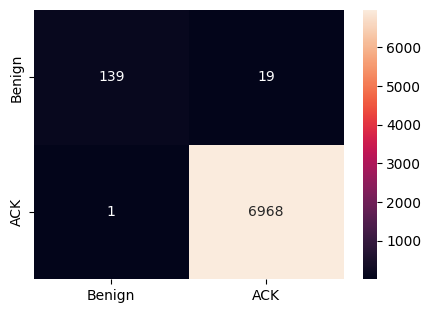





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  KNN   0.022      0.5   0.511    0.5  0.022      0    0.5    0         0.306
 1  ACK           0    1     1  KNN   0.022      0.5   0.511    0.5  0.022      0    0.5    0         0.307
 2  ACK           0    1     2  KNN   0.022      0.5   0.511    0.5  0.022      0    0.5    0         0.287
 3  ACK           0    1     3  KNN   0.022      0.5   0.511    0.5  0.022      0    0.5    0.003     0.284
 4  ACK           0    1     4  KNN   0.022      0.5   0.511    0.5  0.022      0    0.5    0.002     0.285
 5  ACK           0    1     5  KNN   0.022      0.5   0.511    0.5  0.022      0    0.5    0.003     0.286
 6  ACK           0    1     6  KNN   0.022      0.5   0.511    0.5  0.022      0    0.5    0.003     0.301
 7  ACK           0    1

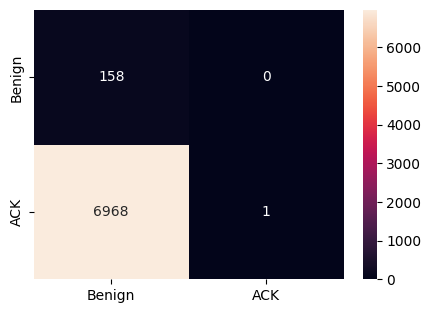





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  NB    0.992    0.816   0.996  0.816  0.886  0.771  0.816    0.001     0.003
 1  ACK           0    1     1  NB    0.992    0.816   0.996  0.816  0.886  0.771  0.816    0         0
 2  ACK           0    1     2  NB    0.992    0.816   0.996  0.816  0.886  0.771  0.816    0         0
 3  ACK           0    1     3  NB    0.992    0.816   0.996  0.816  0.886  0.771  0.816    0         0
 4  ACK           0    1     4  NB    0.992    0.816   0.996  0.816  0.886  0.771  0.816    0.002     0.002
 5  ACK           0    1     5  NB    0.992    0.816   0.996  0.816  0.886  0.771  0.816    0.001     0.003
 6  ACK           0    1     6  NB    0.992    0.816   0.996  0.816  0.886  0.771  0.816    0         0.013
 7  ACK           0    1     7  NB  

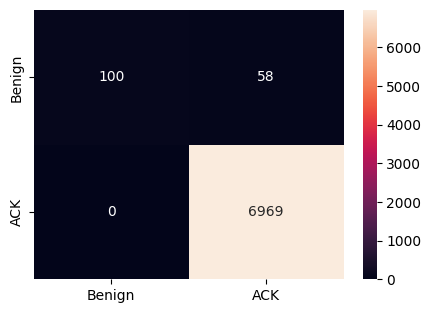





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  XGB   0.997     0.94   0.999   0.94  0.967  0.935   0.94    0.729     0.012
 1  ACK           0    1     1  XGB   0.997     0.94   0.999   0.94  0.967  0.935   0.94    0.781     0.025
 2  ACK           0    1     2  XGB   0.997     0.94   0.999   0.94  0.967  0.935   0.94    0.964     0.014
 3  ACK           0    1     3  XGB   0.997     0.94   0.999   0.94  0.967  0.935   0.94    0.908     0.016
 4  ACK           0    1     4  XGB   0.997     0.94   0.999   0.94  0.967  0.935   0.94    1.003     0.022
 5  ACK           0    1     5  XGB   0.997     0.94   0.999   0.94  0.967  0.935   0.94    1.004     0.026
 6  ACK           0    1     6  XGB   0.997     0.94   0.999   0.94  0.967  0.935   0.94    1.24      0.016
 7  ACK           0    1

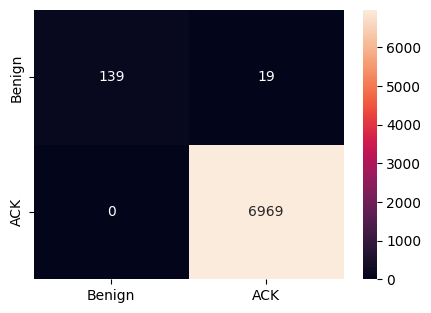





UDP
['Src Port', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Pkt Len Max', 'Pkt Size Avg', 'Subflow Bwd Byts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  LR        1        1       1      1     1      1      1    0.169     0
 1  UDP           0    1     1  LR        1        1       1      1     1      1      1    0.183     0
 2  UDP           0    1     2  LR        1        1       1      1     1      1      1    0.175     0
 3  UDP           0    1     3  LR        1        1       1      1     1      1      1    0.166     0
 4  UDP           0    1     4  LR        1        1       1      1     1      1      1    0.167     0
 5  UDP           0    1     5  LR   

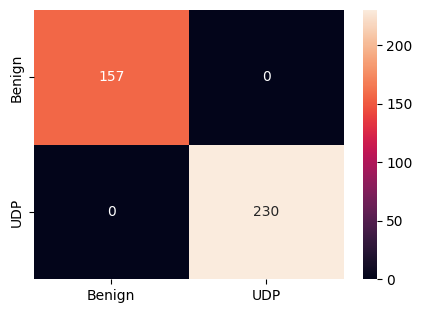





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  DT        1        1       1      1     1      1      1    0.001     0.001
 1  UDP           0    1     1  DT        1        1       1      1     1      1      1    0.002     0
 2  UDP           0    1     2  DT        1        1       1      1     1      1      1    0.002     0.001
 3  UDP           0    1     3  DT        1        1       1      1     1      1      1    0.001     0
 4  UDP           0    1     4  DT        1        1       1      1     1      1      1    0.001     0
 5  UDP           0    1     5  DT        1        1       1      1     1      1      1    0.001     0.001
 6  UDP           0    1     6  DT        1        1       1      1     1      1      1    0.001     0
 7  UDP           0    1     7  DT        1      

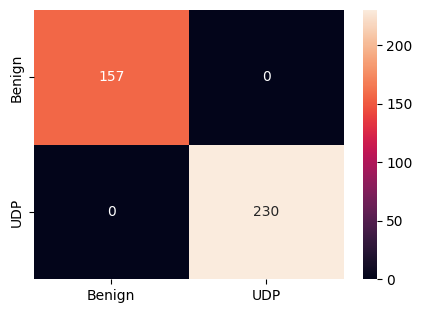





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  RF        1        1       1      1     1      1      1    0.012     0.002
 1  UDP           0    1     1  RF        1        1       1      1     1      1      1    0.013     0.003
 2  UDP           0    1     2  RF        1        1       1      1     1      1      1    0.011     0.001
 3  UDP           0    1     3  RF        1        1       1      1     1      1      1    0.011     0.001
 4  UDP           0    1     4  RF        1        1       1      1     1      1      1    0.017     0.002
 5  UDP           0    1     5  RF        1        1       1      1     1      1      1    0.012     0.002
 6  UDP           0    1     6  RF        1        1       1      1     1      1      1    0.012     0.002
 7  UDP           0    1     7  R

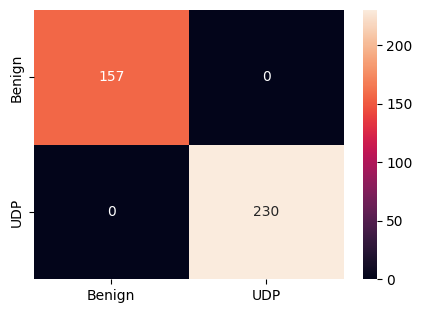





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  KNN   0.496    0.576   0.723  0.576  0.441  0.127  0.576    0.002     0.004
 1  UDP           0    1     1  KNN   0.496    0.576   0.723  0.576  0.441  0.127  0.576    0.001     0
 2  UDP           0    1     2  KNN   0.496    0.576   0.723  0.576  0.441  0.127  0.576    0.001     0.003
 3  UDP           0    1     3  KNN   0.496    0.576   0.723  0.576  0.441  0.127  0.576    0.001     0.004
 4  UDP           0    1     4  KNN   0.496    0.576   0.723  0.576  0.441  0.127  0.576    0.001     0.003
 5  UDP           0    1     5  KNN   0.496    0.576   0.723  0.576  0.441  0.127  0.576    0.002     0.004
 6  UDP           0    1     6  KNN   0.496    0.576   0.723  0.576  0.441  0.127  0.576    0.002     0.004
 7  UDP           0    1    

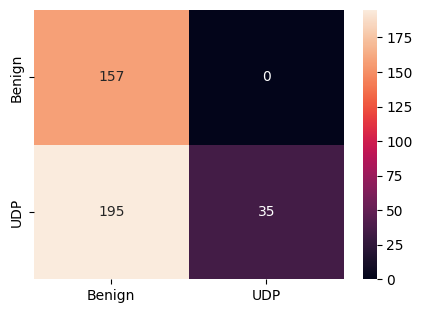





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  NB    0.687    0.718   0.723  0.718  0.687  0.402  0.718    0         0
 1  UDP           0    1     1  NB    0.687    0.718   0.723  0.718  0.687  0.402  0.718    0         0
 2  UDP           0    1     2  NB    0.687    0.718   0.723  0.718  0.687  0.402  0.718    0         0
 3  UDP           0    1     3  NB    0.687    0.718   0.723  0.718  0.687  0.402  0.718    0         0
 4  UDP           0    1     4  NB    0.687    0.718   0.723  0.718  0.687  0.402  0.718    0         0
 5  UDP           0    1     5  NB    0.687    0.718   0.723  0.718  0.687  0.402  0.718    0         0
 6  UDP           0    1     6  NB    0.687    0.718   0.723  0.718  0.687  0.402  0.718    0         0
 7  UDP           0    1     7  NB    0.687    0.718

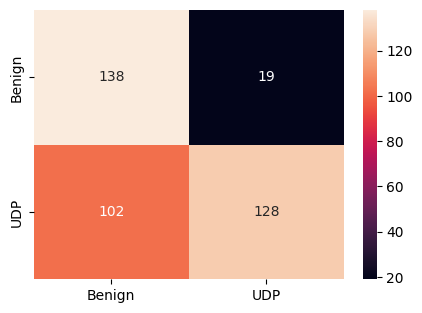





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  XGB       1        1       1      1     1      1      1    0.346     0
 1  UDP           0    1     1  XGB       1        1       1      1     1      1      1    0.359     0
 2  UDP           0    1     2  XGB       1        1       1      1     1      1      1    0.522     0.003
 3  UDP           0    1     3  XGB       1        1       1      1     1      1      1    0.367     0.016
 4  UDP           0    1     4  XGB       1        1       1      1     1      1      1    0.408     0
 5  UDP           0    1     5  XGB       1        1       1      1     1      1      1    0.406     0.006
 6  UDP           0    1     6  XGB       1        1       1      1     1      1      1    0.395     0.006
 7  UDP           0    1     7  XGB       1  

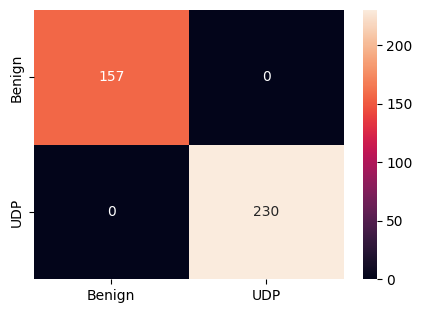





ARP
['Src Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Std', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Active Min', 'Idle Mean', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  LR    0.675    0.704   0.693  0.704  0.674   0.37  0.704    1.304     0
 1  ARP           0    1     1 

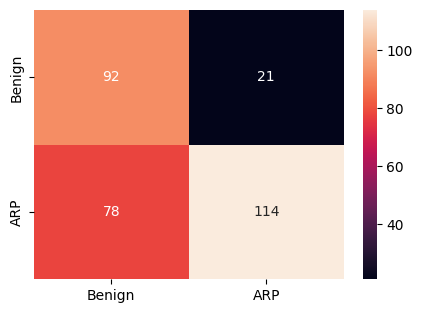





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  DT    0.725    0.736   0.72   0.736  0.718  0.444  0.736    0.012         0
 1  ARP           0    1     1  DT    0.679    0.701   0.688  0.701  0.676  0.369  0.701    0             0
 2  ARP           0    1     2  DT    0.718    0.732   0.717  0.732  0.713  0.435  0.732    0.016         0
 3  ARP           0    1     3  DT    0.679    0.701   0.688  0.701  0.676  0.369  0.701    0.016         0
 4  ARP           0    1     4  DT    0.685    0.703   0.689  0.703  0.681  0.375  0.703    0.016         0
 5  ARP           0    1     5  DT    0.708    0.723   0.708  0.723  0.703  0.416  0.723    0             0
 6  ARP           0    1     6  DT    0.698    0.717   0.702  0.717  0.694  0.401  0.717    0.016         0
 7  ARP           0    1

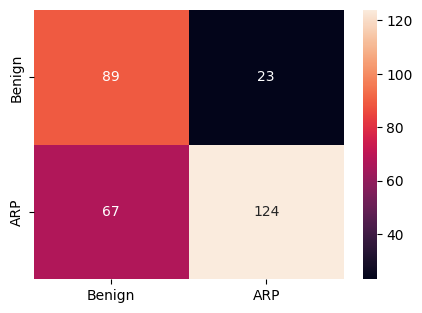





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  RF    0.725    0.752   0.737  0.752  0.722  0.461  0.752    0.09      0.01
 1  ARP           0    1     1  RF    0.731    0.754   0.737  0.754  0.728  0.468  0.754    0.09      0.012
 2  ARP           0    1     2  RF    0.715    0.741   0.726  0.741  0.712  0.44   0.741    0.094     0.011
 3  ARP           0    1     3  RF    0.725    0.75    0.735  0.75   0.722  0.459  0.75     0.101     0.013
 4  ARP           0    1     4  RF    0.738    0.755   0.738  0.755  0.733  0.476  0.755    0.092     0.01
 5  ARP           0    1     5  RF    0.728    0.747   0.731  0.747  0.724  0.459  0.747    0.092     0.009
 6  ARP           0    1     6  RF    0.728    0.751   0.735  0.751  0.725  0.463  0.751    0.085     0.009
 7  ARP           0    1  

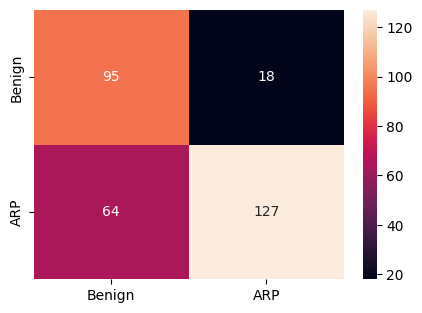





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  ARP           0    1     0  KNN   0.721    0.719   0.708  0.719  0.71  0.423  0.719    0.002     0.005
 1  ARP           0    1     1  KNN   0.721    0.719   0.708  0.719  0.71  0.423  0.719    0.003     0.004
 2  ARP           0    1     2  KNN   0.721    0.719   0.708  0.719  0.71  0.423  0.719    0.003     0.003
 3  ARP           0    1     3  KNN   0.721    0.719   0.708  0.719  0.71  0.423  0.719    0.003     0.004
 4  ARP           0    1     4  KNN   0.721    0.719   0.708  0.719  0.71  0.423  0.719    0.002     0.005
 5  ARP           0    1     5  KNN   0.721    0.719   0.708  0.719  0.71  0.423  0.719    0.002     0.006
 6  ARP           0    1     6  KNN   0.721    0.719   0.708  0.719  0.71  0.423  0.719    0.002     0.004
 7  ARP           0    1     7  K

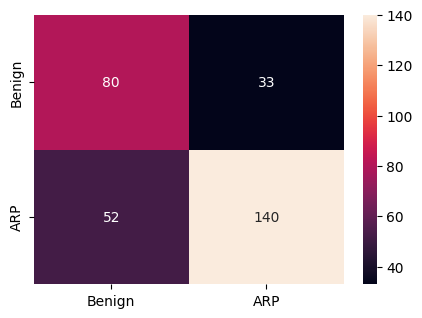





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP           0    1     0  NB    0.554    0.464   0.437  0.464  0.428  -0.082  0.464    0.001     0.001
 1  ARP           0    1     1  NB    0.554    0.464   0.437  0.464  0.428  -0.082  0.464    0.001     0
 2  ARP           0    1     2  NB    0.554    0.464   0.437  0.464  0.428  -0.082  0.464    0.001     0
 3  ARP           0    1     3  NB    0.554    0.464   0.437  0.464  0.428  -0.082  0.464    0.001     0
 4  ARP           0    1     4  NB    0.554    0.464   0.437  0.464  0.428  -0.082  0.464    0.001     0
 5  ARP           0    1     5  NB    0.554    0.464   0.437  0.464  0.428  -0.082  0.464    0.001     0.001
 6  ARP           0    1     6  NB    0.554    0.464   0.437  0.464  0.428  -0.082  0.464    0.001     0
 7  ARP           0    1     7  NB 

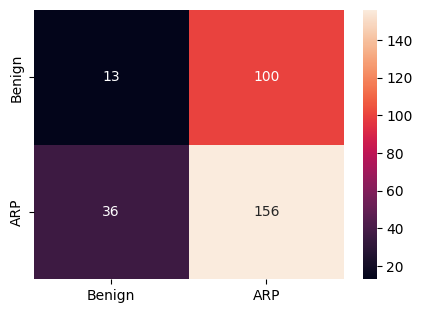





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  XGB   0.734    0.754   0.738  0.754  0.731  0.472  0.754    1.05      0.006
 1  ARP           0    1     1  XGB   0.734    0.754   0.738  0.754  0.731  0.472  0.754    1.213     0.016
 2  ARP           0    1     2  XGB   0.734    0.754   0.738  0.754  0.731  0.472  0.754    1.386     0.004
 3  ARP           0    1     3  XGB   0.734    0.754   0.738  0.754  0.731  0.472  0.754    1.286     0.006
 4  ARP           0    1     4  XGB   0.734    0.754   0.738  0.754  0.731  0.472  0.754    1.349     0.004
 5  ARP           0    1     5  XGB   0.734    0.754   0.738  0.754  0.731  0.472  0.754    1.14      0.003
 6  ARP           0    1     6  XGB   0.734    0.754   0.738  0.754  0.731  0.472  0.754    1.452     0.004
 7  ARP           0    1

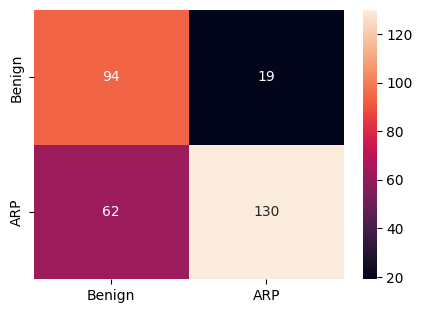





SP
['Tot Fwd Pkts', 'TotLen Fwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow IAT Std', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Header Len', 'Fwd Pkts/s', 'Pkt Len Var', 'SYN Flag Cnt', 'Fwd Seg Size Avg', 'Subflow Bwd Pkts', 'Init Bwd Win Byts', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  LR    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.003     0.001
 1  SP            0    1     1  LR    1        1       1      1      1      1      1        0.003     0
 2  SP            0    1     2  LR    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.002     0.001
 3  SP 

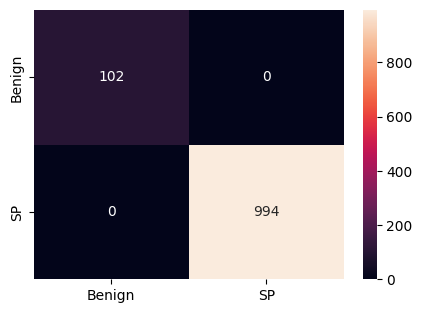





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0         0
 1  SP            0    1     1  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.001     0
 2  SP            0    1     2  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.001     0.001
 3  SP            0    1     3  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.001     0
 4  SP            0    1     4  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.001     0
 5  SP            0    1     5  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.002     0
 6  SP            0    1     6  DT    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.008     0.001
 7  SP            0    1     7  DT    0.999 

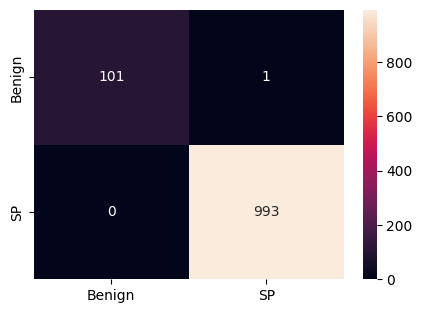





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  RF    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.047     0.01
 1  SP            0    1     1  RF    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.04      0.007
 2  SP            0    1     2  RF    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.037     0.007
 3  SP            0    1     3  RF    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.049     0.007
 4  SP            0    1     4  RF    1        1       1      1      1      1      1        0.047     0.007
 5  SP            0    1     5  RF    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.039     0.006
 6  SP            0    1     6  RF    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.04      0.007
 7  SP            0    1 

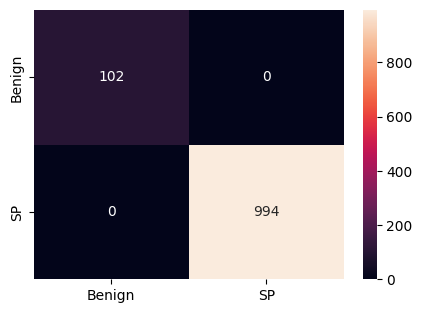





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  KNN   0.971    0.901   0.923  0.901  0.912  0.824  0.901    0.004     0.047
 1  SP            0    1     1  KNN   0.971    0.901   0.923  0.901  0.912  0.824  0.901    0.003     0.047
 2  SP            0    1     2  KNN   0.971    0.901   0.923  0.901  0.912  0.824  0.901    0.003     0.043
 3  SP            0    1     3  KNN   0.971    0.901   0.923  0.901  0.912  0.824  0.901    0.003     0.042
 4  SP            0    1     4  KNN   0.971    0.901   0.923  0.901  0.912  0.824  0.901    0.003     0.049
 5  SP            0    1     5  KNN   0.971    0.901   0.923  0.901  0.912  0.824  0.901    0.003     0.044
 6  SP            0    1     6  KNN   0.971    0.901   0.923  0.901  0.912  0.824  0.901    0.003     0.049
 7  SP            0    1

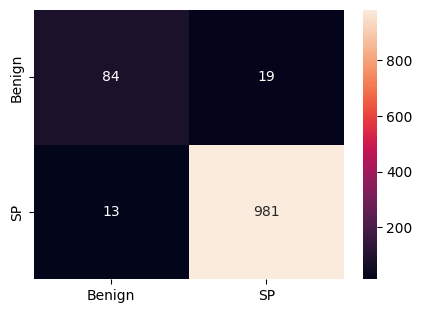





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  NB    0.989    0.942   0.994  0.942  0.966  0.932  0.942    0.001     0.001
 1  SP            0    1     1  NB    0.989    0.942   0.994  0.942  0.966  0.932  0.942    0.001     0.001
 2  SP            0    1     2  NB    0.989    0.942   0.994  0.942  0.966  0.932  0.942    0.003     0
 3  SP            0    1     3  NB    0.989    0.942   0.994  0.942  0.966  0.932  0.942    0.001     0.001
 4  SP            0    1     4  NB    0.989    0.942   0.994  0.942  0.966  0.932  0.942    0.001     0.001
 5  SP            0    1     5  NB    0.989    0.942   0.994  0.942  0.966  0.932  0.942    0.002     0.001
 6  SP            0    1     6  NB    0.989    0.942   0.994  0.942  0.966  0.932  0.942    0.001     0.001
 7  SP            0    1    

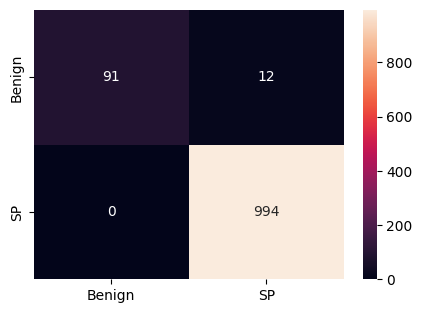





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  XGB   0.999    0.995   0.999  0.995  0.997  0.995  0.995    1.619     0.012
 1  SP            0    1     1  XGB   0.999    0.995   0.999  0.995  0.997  0.995  0.995    1.743     0.007
 2  SP            0    1     2  XGB   0.999    0.995   0.999  0.995  0.997  0.995  0.995    1.472     0.006
 3  SP            0    1     3  XGB   0.999    0.995   0.999  0.995  0.997  0.995  0.995    1.249     0.008
 4  SP            0    1     4  XGB   0.999    0.995   0.999  0.995  0.997  0.995  0.995    1.379     0.008
 5  SP            0    1     5  XGB   0.999    0.995   0.999  0.995  0.997  0.995  0.995    1.834     0.011
 6  SP            0    1     6  XGB   0.999    0.995   0.999  0.995  0.997  0.995  0.995    2.249     0.006
 7  SP            0    1

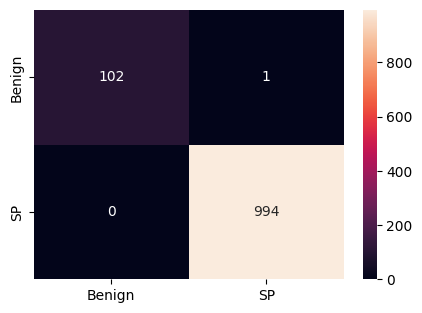





BF
['Tot Bwd Pkts', 'TotLen Fwd Pkts', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Min', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  BF            0    1     0  LR    0.844    0.498   0.423  0.498  0.458  -0.005  0.498    0.008     0.001
 1  BF            0    1     1  LR    0.844    0.498   0.423  0.498  0.458  -0.005  0.498    0.008     0
 2  BF            0    1     2  LR    0.844    0.498   0.423  0.498  0.458  -0.005  0.498    0.009     0.001
 3  BF            0    1     3  LR    0.844    0.498   0.423  0.498  0.458  -0.005  0.498    0.013     0
 4  BF            0    1     4  LR    0.844    0.498   0.423  0.498  0.458  -0.005  0.498    0.006     0
 5  BF            0    1     5  LR    0.844    0.498 

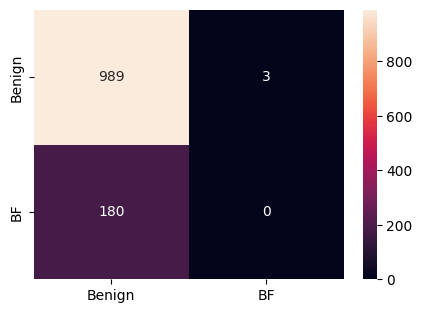





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  DT    0.881    0.743   0.774  0.743  0.757  0.514  0.743    0.006     0
 1  BF            0    1     1  DT    0.878    0.741   0.768  0.741  0.753  0.507  0.741    0         0
 2  BF            0    1     2  DT    0.884    0.756   0.78   0.756  0.767  0.535  0.756    0.006     0.001
 3  BF            0    1     3  DT    0.891    0.751   0.8    0.751  0.772  0.545  0.751    0.006     0
 4  BF            0    1     4  DT    0.895    0.765   0.807  0.765  0.784  0.568  0.765    0.006     0.001
 5  BF            0    1     5  DT    0.892    0.756   0.8    0.756  0.775  0.552  0.756    0.004     0
 6  BF            0    1     6  DT    0.896    0.766   0.809  0.766  0.785  0.57   0.766    0.005     0
 7  BF            0    1     7  DT    0.875 

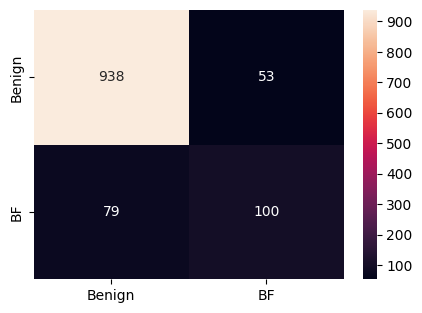





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  RF    0.913    0.764   0.874  0.764  0.805  0.612  0.764    0.342     0.045
 1  BF            0    1     1  RF    0.916    0.766   0.885  0.766  0.809  0.621  0.766    0.325     0.036
 2  BF            0    1     2  RF    0.916    0.766   0.885  0.766  0.809  0.621  0.766    0.315     0.036
 3  BF            0    1     3  RF    0.916    0.766   0.888  0.766  0.811  0.624  0.766    0.35      0.033
 4  BF            0    1     4  RF    0.916    0.766   0.885  0.766  0.809  0.621  0.766    0.36      0.036
 5  BF            0    1     5  RF    0.917    0.771   0.887  0.771  0.814  0.63   0.771    0.366     0.037
 6  BF            0    1     6  RF    0.915    0.765   0.881  0.765  0.808  0.618  0.765    0.318     0.037
 7  BF            0    1

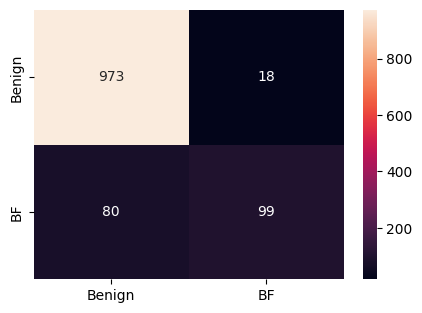





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  KNN   0.869    0.709   0.749  0.709  0.726  0.452  0.709    0.002     0.009
 1  BF            0    1     1  KNN   0.869    0.709   0.749  0.709  0.726  0.452  0.709    0.002     0.008
 2  BF            0    1     2  KNN   0.869    0.709   0.749  0.709  0.726  0.452  0.709    0.003     0.007
 3  BF            0    1     3  KNN   0.869    0.709   0.749  0.709  0.726  0.452  0.709    0.002     0.008
 4  BF            0    1     4  KNN   0.869    0.709   0.749  0.709  0.726  0.452  0.709    0.001     0.008
 5  BF            0    1     5  KNN   0.869    0.709   0.749  0.709  0.726  0.452  0.709    0.002     0.008
 6  BF            0    1     6  KNN   0.869    0.709   0.749  0.709  0.726  0.452  0.709    0.001     0.008
 7  BF            0    1

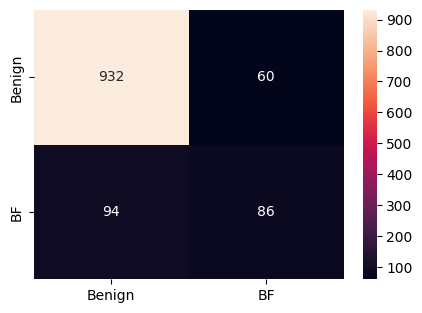





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  NB    0.829    0.517   0.562  0.517  0.506   0.05  0.517    0.001     0
 1  BF            0    1     1  NB    0.829    0.517   0.562  0.517  0.506   0.05  0.517    0.001     0.001
 2  BF            0    1     2  NB    0.829    0.517   0.562  0.517  0.506   0.05  0.517    0.001     0.001
 3  BF            0    1     3  NB    0.829    0.517   0.562  0.517  0.506   0.05  0.517    0.001     0
 4  BF            0    1     4  NB    0.829    0.517   0.562  0.517  0.506   0.05  0.517    0.001     0
 5  BF            0    1     5  NB    0.829    0.517   0.562  0.517  0.506   0.05  0.517    0.001     0
 6  BF            0    1     6  NB    0.829    0.517   0.562  0.517  0.506   0.05  0.517    0.001     0.001
 7  BF            0    1     7  NB    0.

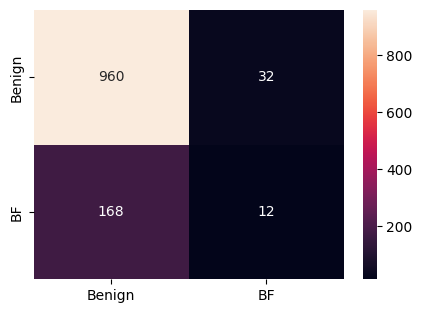





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  XGB   0.912    0.762   0.873  0.762  0.803  0.608  0.762    2.046     0.028
 1  BF            0    1     1  XGB   0.912    0.762   0.873  0.762  0.803  0.608  0.762    2.303     0.017
 2  BF            0    1     2  XGB   0.912    0.762   0.873  0.762  0.803  0.608  0.762    1.732     0.016
 3  BF            0    1     3  XGB   0.912    0.762   0.873  0.762  0.803  0.608  0.762    2.023     0.024
 4  BF            0    1     4  XGB   0.912    0.762   0.873  0.762  0.803  0.608  0.762    6.328     0.025
 5  BF            0    1     5  XGB   0.912    0.762   0.873  0.762  0.803  0.608  0.762    5.793     0.016
 6  BF            0    1     6  XGB   0.912    0.762   0.873  0.762  0.803  0.608  0.762    6.67      0.016
 7  BF            0    1

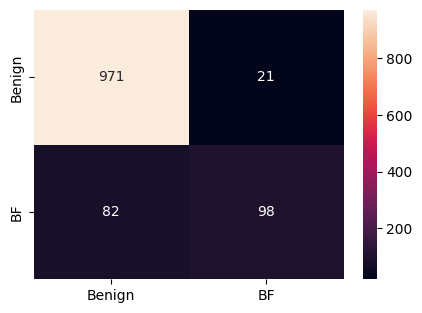

In [20]:
folder("results/val/")

for file in file_list:
    print(file)
    feature=feature_list[file]
    train=file_list[file][0]
    test=file_list[file][1]
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/val/{file}_VAL_chosed_output_ML_.csv"
    target_names=["Benign",file]
    ML(train,test,output_csv,feature,file,0)   


# TEST

In [21]:
file_list={'SYN': ['./INPUT/SM/DoS-SYN-1.csv',  './INPUT/TEST/small_Edge_IIoT_DDoS_TCP_SYN_Flood_Attacks_00000_20211124180237._SW.csv'],
 'HTTP': ['./INPUT/SM/MB-HTTP-4.csv',  './INPUT/TEST/NetatmoCamHTTPFlood_1_SW.csv'],
'ACK': ['./INPUT/SM/MB-ACK-4.csv',  './INPUT/TEST/NetatmoCamTCPFlood_3_SW.csv'],
 'UDP': ['./INPUT/SM/MB-UDP-4.csv',  './INPUT/TEST/Bot_IoT_UDP_DDoS_00001._SW.csv'],
 'ARP': ['./INPUT/SM/MitM-ARP-6.csv',   './INPUT/TEST/Kitsune_ARP_MitM._SW.csv'],
 'SP': ['./INPUT/SM/Scan-Port-3.csv', './INPUT/TEST/IoT_ENV_[Port_scan]Google_Home_Mini_SW.csv'],
 'BF': ['./INPUT/SM/MB-BF-5.csv',  './INPUT/TEST/AmcrestCamBruteForce_1_SW.csv'],
 'OS': ['./INPUT/SM/Scan-OS-3.csv',  './INPUT/TEST/IoT_ENV_[OS_Service_Detection]Google_Home_Mini_SW.csv'],
"SCHD":['./INPUT/SM/Scan-HDis-3.csv','./INPUT/SM/MB-HDis-3.csv'],
"MHDis":['./INPUT/SM/MB-HDis-3.csv','./INPUT/SM/Scan-HDis-3.csv' ]}

In [22]:
file_list={"SYN":[ './csvs/dos-synflooding-1-dec.pcap_Flow.csv', './csvs/small_Edge_IIoT_DDoS_TCP_SYN_Flood_Attacks_00000_20211124180237.pcap_Flow.csv',],
"HTTP":['./csvs/mirai-httpflooding-4-dec.pcap_Flow.csv', './csvs/NetatmoCamHTTPFlood_1.pcap_Flow.csv'],
"ACK":['./csvs/mirai-ackflooding-4-dec.pcap_Flow.csv','./csvs/NetatmoCamTCPFlood_3.pcap_Flow.csv'],
"UDP":[ './csvs/mirai-udpflooding-4-dec.pcap_Flow.csv','./csvs/Bot_IoT_UDP_DDoS_00001.pcap_Flow.csv'],
"ARP":[ './csvs/mitm-arpspoofing-6-dec.pcap_Flow.csv', './csvs/kitsune_ARP.csv'],
"SP":['./csvs/scan-hostport-3-dec.pcap_Flow.csv','./csvs/scan-hostport-6-dec.pcap_Flow.csv'],
"BF":[ './csvs/mirai-hostbruteforce-5-dec.pcap_Flow.csv','./csvs/AmcrestCamBruteForce_1.pcap_Flow.csv']}

SYN
['Src Port', 'Protocol', 'Flow Duration', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Std', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Fwd Pkts/s', 'Pkt Len Min', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'SYN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Active Mean', 'Active Std', 'Active Max', 'Idle Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  LR    0.731    0.765     0.5  0.765  0.422      0  0.765    0.927     0.094
 1  SYN           1    1     1  LR  

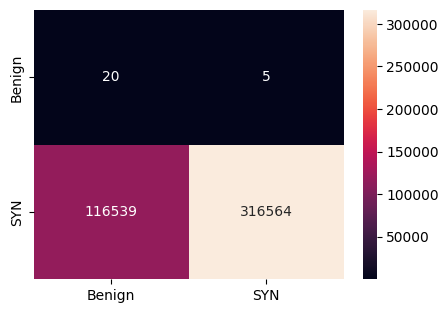





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  DT    0.122    0.561   0.5    0.561  0.109  0      0.561    0.063     0.079
 1  SYN           1    1     1  DT    0.122    0.561   0.5    0.561  0.109  0      0.561    0.063     0.079
 2  SYN           1    1     2  DT    0.122    0.561   0.5    0.561  0.109  0      0.561    0.063     0.094
 3  SYN           1    1     3  DT    0.122    0.561   0.5    0.561  0.109  0      0.561    0.063     0.079
 4  SYN           1    1     4  DT    0.122    0.561   0.5    0.561  0.109  0      0.561    0.063     0.079
 5  SYN           1    1     5  DT    0.122    0.561   0.5    0.561  0.109  0      0.561    0.11      0.095
 6  SYN           1    1     6  DT    0.122    0.561   0.5    0.561  0.109  0      0.561    0.057     0.084
 7  SYN           1    1

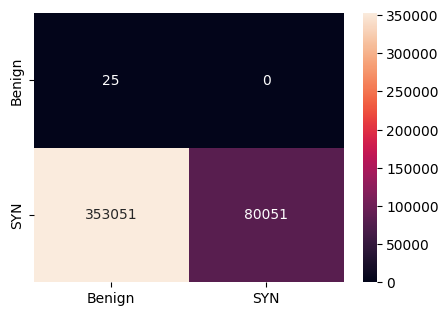





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SYN           1    1     0  RF        0      0.5       0    0.5     0      0    0.5    1.036     2.592
 1  SYN           1    1     1  RF        0      0.5       0    0.5     0      0    0.5    1.156     2.458
 2  SYN           1    1     2  RF        0      0.5       0    0.5     0      0    0.5    1.081     2.541
 3  SYN           1    1     3  RF        0      0.5       0    0.5     0      0    0.5    1.05      2.621
 4  SYN           1    1     4  RF        0      0.5       0    0.5     0      0    0.5    1.178     2.529
 5  SYN           1    1     5  RF        0      0.5       0    0.5     0      0    0.5    1.003     3.841
 6  SYN           1    1     6  RF        0      0.5       0    0.5     0      0    0.5    1.061     2.498
 7  SYN           1    1     7  R

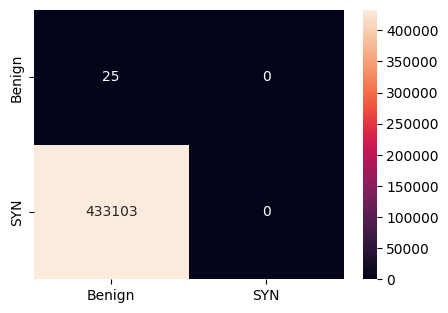





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  KNN    0.58     0.51     0.5   0.51  0.367      0   0.51    0        19.033
 1  SYN           1    1     1  KNN    0.58     0.51     0.5   0.51  0.367      0   0.51    0        19.08
 2  SYN           1    1     2  KNN    0.58     0.51     0.5   0.51  0.367      0   0.51    0.013    18.969
 3  SYN           1    1     3  KNN    0.58     0.51     0.5   0.51  0.367      0   0.51    0        19.03
 4  SYN           1    1     4  KNN    0.58     0.51     0.5   0.51  0.367      0   0.51    0.016    17.926
 5  SYN           1    1     5  KNN    0.58     0.51     0.5   0.51  0.367      0   0.51    0.005    18.311
 6  SYN           1    1     6  KNN    0.58     0.51     0.5   0.51  0.367      0   0.51    0.006    19.235
 7  SYN           1    1  

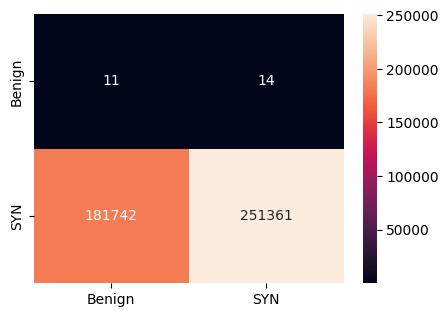





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  NB    0.592    0.676     0.5  0.676  0.372      0  0.676    0.012     0.462
 1  SYN           1    1     1  NB    0.592    0.676     0.5  0.676  0.372      0  0.676    0.031     0.821
 2  SYN           1    1     2  NB    0.592    0.676     0.5  0.676  0.372      0  0.676    0.016     0.455
 3  SYN           1    1     3  NB    0.592    0.676     0.5  0.676  0.372      0  0.676    0         0.455
 4  SYN           1    1     4  NB    0.592    0.676     0.5  0.676  0.372      0  0.676    0.016     0.44
 5  SYN           1    1     5  NB    0.592    0.676     0.5  0.676  0.372      0  0.676    0.016     0.471
 6  SYN           1    1     6  NB    0.592    0.676     0.5  0.676  0.372      0  0.676    0.031     0.535
 7  SYN           1    1 

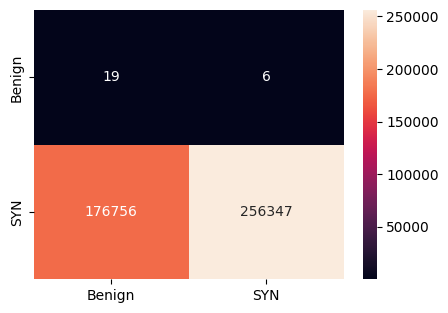





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SYN           1    1     0  XGB   0.123    0.562     0.5  0.562  0.11      0  0.562    0.636     0.326
 1  SYN           1    1     1  XGB   0.123    0.562     0.5  0.562  0.11      0  0.562    0.639     0.369
 2  SYN           1    1     2  XGB   0.123    0.562     0.5  0.562  0.11      0  0.562    0.768     0.348
 3  SYN           1    1     3  XGB   0.123    0.562     0.5  0.562  0.11      0  0.562    0.586     0.386
 4  SYN           1    1     4  XGB   0.123    0.562     0.5  0.562  0.11      0  0.562    0.703     0.32
 5  SYN           1    1     5  XGB   0.123    0.562     0.5  0.562  0.11      0  0.562    0.77      0.309
 6  SYN           1    1     6  XGB   0.123    0.562     0.5  0.562  0.11      0  0.562    0.645     0.333
 7  SYN           1    1     7  XG

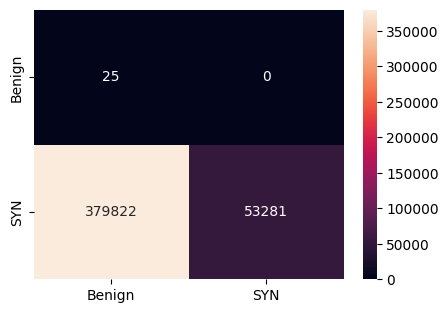





HTTP
['Dst Port', 'Flow Duration', 'Flow IAT Max', 'Fwd IAT Tot', 'FIN Flag Cnt', 'SYN Flag Cnt', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  HTTP          1    1     0  LR    0.957    0.975   0.882  0.975  0.92  0.841  0.975    0.025     0
 1  HTTP          1    1     1  LR    0.957    0.975   0.882  0.975  0.92  0.841  0.975    0.009     0
 2  HTTP          1    1     2  LR    0.957    0.975   0.882  0.975  0.92  0.841  0.975    0.022     0.002
 3  HTTP          1    1     3  LR    0.957    0.975   0.882  0.975  0.92  0.841  0.975    0.024     0
 4  HTTP          1    1     4  LR    0.957    0.975   0.882  0.975  0.92  0.841  0.975    0.025     0.005
 5  HTTP          1    1     5  LR    0.957    0.975   0.882  0.975  0.92  0.841  0.975    0.02      0.004
 6  HTTP          1    1     6  LR    0.957  

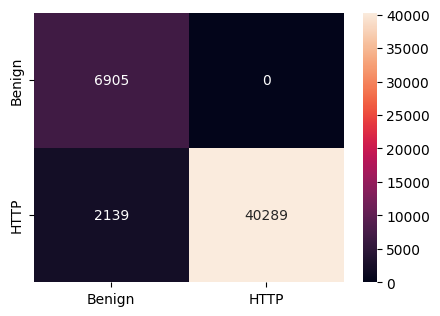





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          1    1     0  DT    0.724    0.839   0.668  0.839  0.656  0.372  0.839    0         0.016
 1  HTTP          1    1     1  DT    0.864    0.921   0.754  0.921  0.794  0.598  0.921    0         0
 2  HTTP          1    1     2  DT    0.843    0.909   0.736  0.909  0.771  0.557  0.909    0         0
 3  HTTP          1    1     3  DT    0.701    0.826   0.659  0.826  0.637  0.345  0.826    0         0.016
 4  HTTP          1    1     4  DT    0.852    0.914   0.743  0.914  0.78   0.573  0.914    0         0
 5  HTTP          1    1     5  DT    0.677    0.812   0.651  0.812  0.617  0.318  0.812    0         0.013
 6  HTTP          1    1     6  DT    0.682    0.815   0.653  0.815  0.621  0.323  0.815    0         0.016
 7  HTTP          1    1     7  DT  

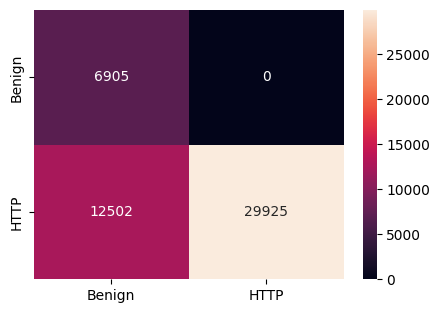





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          1    1     0  RF    0.648    0.796   0.642  0.796  0.593  0.288  0.796    0.063     0.034
 1  HTTP          1    1     1  RF    0.652    0.798   0.643  0.798  0.596  0.292  0.798    0.068     0.042
 2  HTTP          1    1     2  RF    0.651    0.797   0.643  0.797  0.596  0.291  0.797    0.063     0.047
 3  HTTP          1    1     3  RF    0.646    0.794   0.642  0.794  0.591  0.286  0.794    0.058     0.043
 4  HTTP          1    1     4  RF    0.654    0.799   0.644  0.799  0.598  0.294  0.799    0.063     0.036
 5  HTTP          1    1     5  RF    0.655    0.8     0.644  0.8    0.599  0.295  0.8      0.063     0.047
 6  HTTP          1    1     6  RF    0.656    0.8     0.645  0.8    0.599  0.296  0.8      0.047     0.047
 7  HTTP          1    1

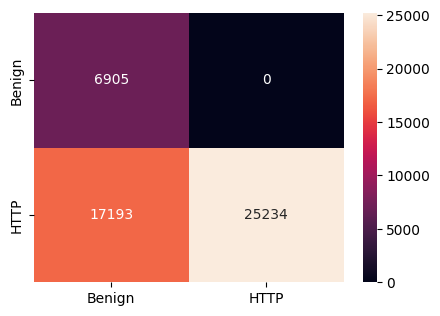





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          1    1     0  KNN   0.614    0.775   0.633  0.775  0.566  0.256  0.775        0     0.189
 1  HTTP          1    1     1  KNN   0.614    0.775   0.633  0.775  0.566  0.256  0.775        0     0.192
 2  HTTP          1    1     2  KNN   0.614    0.775   0.633  0.775  0.566  0.256  0.775        0     0.167
 3  HTTP          1    1     3  KNN   0.614    0.775   0.633  0.775  0.566  0.256  0.775        0     0.204
 4  HTTP          1    1     4  KNN   0.614    0.775   0.633  0.775  0.566  0.256  0.775        0     0.204
 5  HTTP          1    1     5  KNN   0.614    0.775   0.633  0.775  0.566  0.256  0.775        0     0.22
 6  HTTP          1    1     6  KNN   0.614    0.775   0.633  0.775  0.566  0.256  0.775        0     0.171
 7  HTTP          1    1 

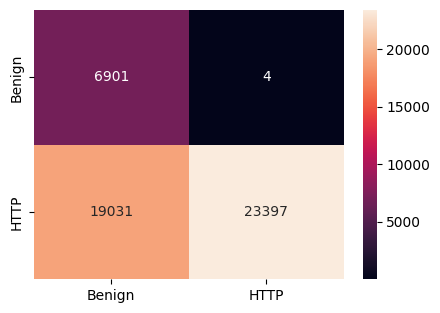





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          1    1     0  NB    0.985    0.991   0.952  0.991  0.971  0.941  0.991    0         0.016
 1  HTTP          1    1     1  NB    0.985    0.991   0.952  0.991  0.971  0.941  0.991    0.001     0.01
 2  HTTP          1    1     2  NB    0.985    0.991   0.952  0.991  0.971  0.941  0.991    0         0
 3  HTTP          1    1     3  NB    0.985    0.991   0.952  0.991  0.971  0.941  0.991    0         0.015
 4  HTTP          1    1     4  NB    0.985    0.991   0.952  0.991  0.971  0.941  0.991    0         0.016
 5  HTTP          1    1     5  NB    0.985    0.991   0.952  0.991  0.971  0.941  0.991    0         0.016
 6  HTTP          1    1     6  NB    0.985    0.991   0.952  0.991  0.971  0.941  0.991    0         0.016
 7  HTTP          1    1     

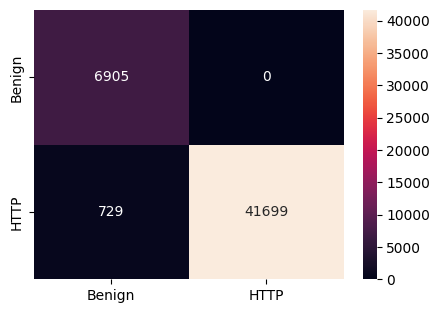





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          1    1     0  XGB   0.719    0.837   0.666  0.837  0.652  0.366  0.837    2.073     0.182
 1  HTTP          1    1     1  XGB   0.719    0.837   0.666  0.837  0.652  0.366  0.837    1.589     0.181
 2  HTTP          1    1     2  XGB   0.719    0.837   0.666  0.837  0.652  0.366  0.837    1.998     0.173
 3  HTTP          1    1     3  XGB   0.719    0.837   0.666  0.837  0.652  0.366  0.837    1.944     0.172
 4  HTTP          1    1     4  XGB   0.719    0.837   0.666  0.837  0.652  0.366  0.837    2.01      0.173
 5  HTTP          1    1     5  XGB   0.719    0.837   0.666  0.837  0.652  0.366  0.837    2.056     0.173
 6  HTTP          1    1     6  XGB   0.719    0.837   0.666  0.837  0.652  0.366  0.837    1.555     0.176
 7  HTTP          1    1

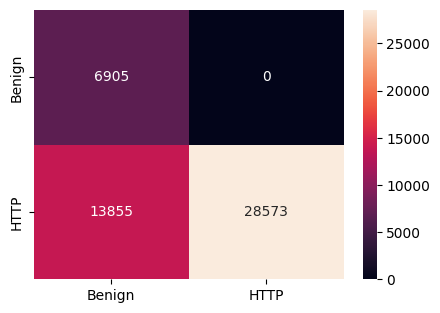





ACK
['TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Flow Byts/s', 'Bwd IAT Std', 'Pkt Len Max', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ACK           1    1     0  LR    0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.031     0
 1  ACK           1    1     1  LR    0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.04      0.001
 2  ACK           1    1     2  LR    0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.048     0
 3  ACK           1    1     3  LR    0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.041     0
 4  ACK           1    1     4  LR    0.116    0.443   0.375  0.44

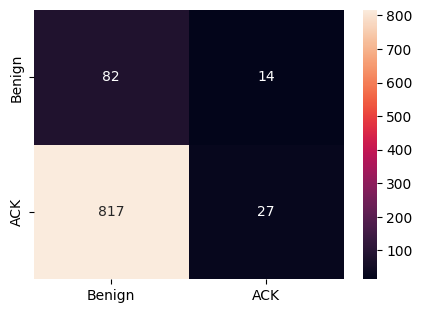





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ACK           1    1     0  DT    0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.001     0
 1  ACK           1    1     1  DT    0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0         0
 2  ACK           1    1     2  DT    0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.001     0.001
 3  ACK           1    1     3  DT    0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.001     0.001
 4  ACK           1    1     4  DT    0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.001     0.001
 5  ACK           1    1     5  DT    0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0         0
 6  ACK           1    1     6  DT    0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.001     0.001
 7  ACK           1    1   

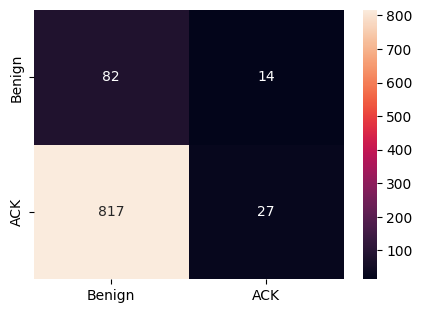





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ACK           1    1     0  RF    0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.501     0.034
 1  ACK           1    1     1  RF    0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.322     0.037
 2  ACK           1    1     2  RF    0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.342     0.021
 3  ACK           1    1     3  RF    0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.339     0.033
 4  ACK           1    1     4  RF    0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.338     0.043
 5  ACK           1    1     5  RF    0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.335     0.034
 6  ACK           1    1     6  RF    0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.356     0.037
 7  ACK        

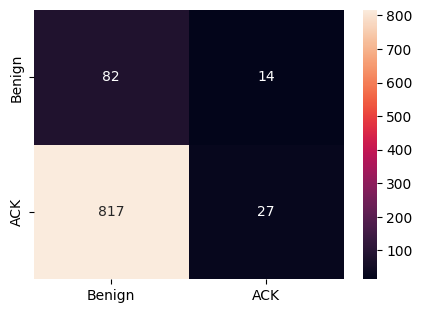





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           1    1     0  KNN   0.102      0.5   0.051    0.5  0.093      0    0.5    0.004     0.02
 1  ACK           1    1     1  KNN   0.102      0.5   0.051    0.5  0.093      0    0.5    0.003     0.021
 2  ACK           1    1     2  KNN   0.102      0.5   0.051    0.5  0.093      0    0.5    0.003     0.02
 3  ACK           1    1     3  KNN   0.102      0.5   0.051    0.5  0.093      0    0.5    0.003     0.021
 4  ACK           1    1     4  KNN   0.102      0.5   0.051    0.5  0.093      0    0.5    0.003     0.021
 5  ACK           1    1     5  KNN   0.102      0.5   0.051    0.5  0.093      0    0.5    0.004     0.02
 6  ACK           1    1     6  KNN   0.102      0.5   0.051    0.5  0.093      0    0.5    0.003     0.021
 7  ACK           1    1   

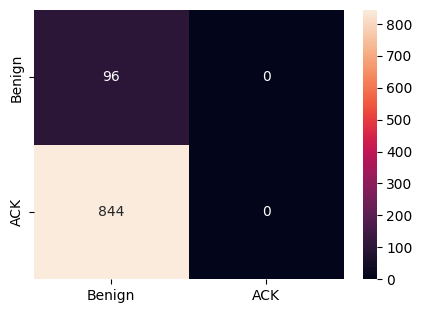





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ACK           1    1     0  NB    0.118    0.444   0.383  0.444  0.115  -0.024  0.444    0.001     0.001
 1  ACK           1    1     1  NB    0.118    0.444   0.383  0.444  0.115  -0.024  0.444    0.001     0
 2  ACK           1    1     2  NB    0.118    0.444   0.383  0.444  0.115  -0.024  0.444    0.001     0.001
 3  ACK           1    1     3  NB    0.118    0.444   0.383  0.444  0.115  -0.024  0.444    0.001     0.001
 4  ACK           1    1     4  NB    0.118    0.444   0.383  0.444  0.115  -0.024  0.444    0.001     0.001
 5  ACK           1    1     5  NB    0.118    0.444   0.383  0.444  0.115  -0.024  0.444    0.001     0.001
 6  ACK           1    1     6  NB    0.118    0.444   0.383  0.444  0.115  -0.024  0.444    0.001     0
 7  ACK           1    

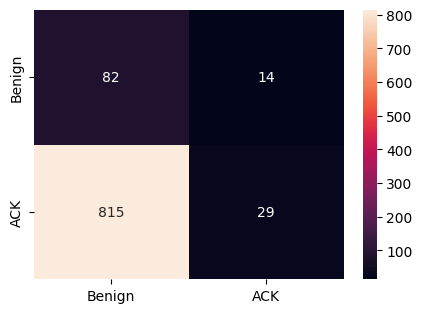





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ACK           1    1     0  XGB   0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.788     0.016
 1  ACK           1    1     1  XGB   0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.731     0
 2  ACK           1    1     2  XGB   0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.754     0
 3  ACK           1    1     3  XGB   0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.708     0.016
 4  ACK           1    1     4  XGB   0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.647     0.016
 5  ACK           1    1     5  XGB   0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.63      0.003
 6  ACK           1    1     6  XGB   0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.616     0.002
 7  ACK           1    

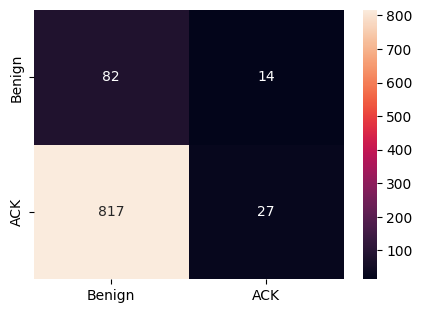





UDP
['Src Port', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Pkt Len Max', 'Pkt Size Avg', 'Subflow Bwd Byts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  LR    0.001      0.5   0.001    0.5  0.001      0    0.5    0.123     0.018
 1  UDP           1    1     1  LR    0.001      0.5   0.001    0.5  0.001      0    0.5    0.148     0.006
 2  UDP           1    1     2  LR    0.001      0.5   0.001    0.5  0.001      0    0.5    0.175     0
 3  UDP           1    1     3  LR    0.001      0.5   0.001    0.5  0.001      0    0.5    0.141     0.016
 4  UDP           1    1     4  LR    0.001      0.5   0.001    0.5  0.001      0    0.5    0.122     0.013
 5  UDP       

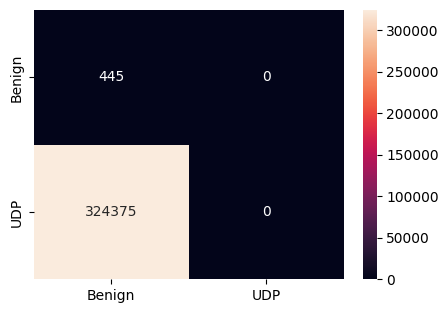





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  UDP           1    1     0  DT    0.001    0.363       0  0.363  0.001  -0.001  0.363    0         0.031
 1  UDP           1    1     1  DT    0.001    0.363       0  0.363  0.001  -0.001  0.363    0.002     0.028
 2  UDP           1    1     2  DT    0.001    0.363       0  0.363  0.001  -0.001  0.363    0.009     0.023
 3  UDP           1    1     3  DT    0.001    0.363       0  0.363  0.001  -0.001  0.363    0         0.016
 4  UDP           1    1     4  DT    0.001    0.363       0  0.363  0.001  -0.001  0.363    0         0.031
 5  UDP           1    1     5  DT    0.001    0.363       0  0.363  0.001  -0.001  0.363    0         0.031
 6  UDP           1    1     6  DT    0.001    0.363       0  0.363  0.001  -0.001  0.363    0         0.031
 7  UDP        

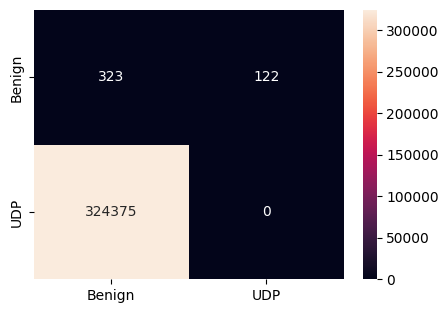





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  UDP           1    1     0  RF    0.001    0.363   0      0.363  0.001  -0.001  0.363    0.016     0.183
 1  UDP           1    1     1  RF    0.001    0.5     0.001  0.5    0.001   0      0.5      0.016     0.189
 2  UDP           1    1     2  RF    0.001    0.363   0      0.363  0.001  -0.001  0.363    0.016     0.188
 3  UDP           1    1     3  RF    0.001    0.5     0.001  0.5    0.001   0      0.5      0.016     0.194
 4  UDP           1    1     4  RF    0.001    0.5     0.001  0.5    0.001   0      0.5      0         0.204
 5  UDP           1    1     5  RF    0.001    0.363   0      0.363  0.001  -0.001  0.363    0.025     0.18
 6  UDP           1    1     6  RF    0.001    0.363   0      0.363  0.001  -0.001  0.363    0         0.199
 7  UDP         

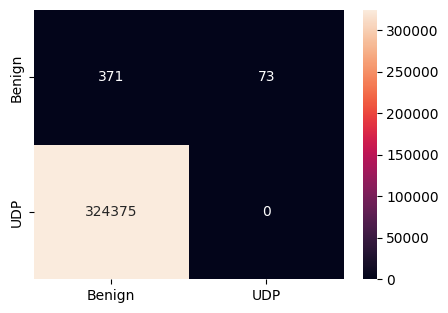





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  KNN   0.001      0.5   0.001    0.5  0.001      0    0.5        0     1.282
 1  UDP           1    1     1  KNN   0.001      0.5   0.001    0.5  0.001      0    0.5        0     1.272
 2  UDP           1    1     2  KNN   0.001      0.5   0.001    0.5  0.001      0    0.5        0     1.288
 3  UDP           1    1     3  KNN   0.001      0.5   0.001    0.5  0.001      0    0.5        0     1.295
 4  UDP           1    1     4  KNN   0.001      0.5   0.001    0.5  0.001      0    0.5        0     1.302
 5  UDP           1    1     5  KNN   0.001      0.5   0.001    0.5  0.001      0    0.5        0     1.304
 6  UDP           1    1     6  KNN   0.001      0.5   0.001    0.5  0.001      0    0.5        0     1.292
 7  UDP           1    1

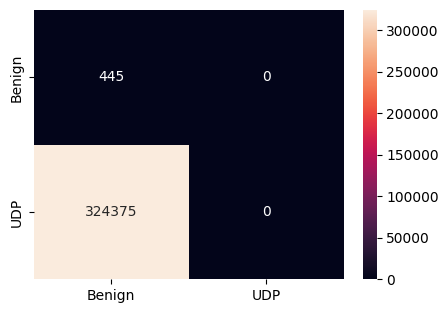





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  NB    0.001    0.499   0.001  0.499  0.001     -0  0.499    0         0.142
 1  UDP           1    1     1  NB    0.001    0.499   0.001  0.499  0.001     -0  0.499    0         0.141
 2  UDP           1    1     2  NB    0.001    0.499   0.001  0.499  0.001     -0  0.499    0         0.126
 3  UDP           1    1     3  NB    0.001    0.499   0.001  0.499  0.001     -0  0.499    0         0.126
 4  UDP           1    1     4  NB    0.001    0.499   0.001  0.499  0.001     -0  0.499    0         0.125
 5  UDP           1    1     5  NB    0.001    0.499   0.001  0.499  0.001     -0  0.499    0         0.094
 6  UDP           1    1     6  NB    0.001    0.499   0.001  0.499  0.001     -0  0.499    0         0.126
 7  UDP           1    1

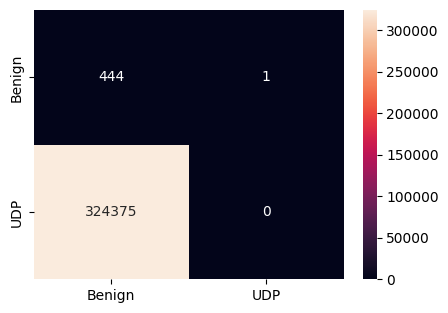





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  UDP           1    1     0  XGB   0.001    0.363       0  0.363  0.001  -0.001  0.363    0.394     0.175
 1  UDP           1    1     1  XGB   0.001    0.363       0  0.363  0.001  -0.001  0.363    0.336     0.192
 2  UDP           1    1     2  XGB   0.001    0.363       0  0.363  0.001  -0.001  0.363    0.442     0.211
 3  UDP           1    1     3  XGB   0.001    0.363       0  0.363  0.001  -0.001  0.363    0.357     0.246
 4  UDP           1    1     4  XGB   0.001    0.363       0  0.363  0.001  -0.001  0.363    0.406     0.223
 5  UDP           1    1     5  XGB   0.001    0.363       0  0.363  0.001  -0.001  0.363    0.457     0.22
 6  UDP           1    1     6  XGB   0.001    0.363       0  0.363  0.001  -0.001  0.363    0.426     0.219
 7  UDP         

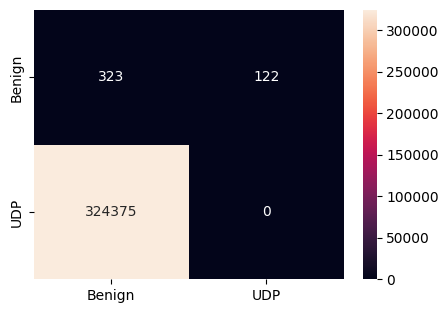





ARP
['Src Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Std', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Active Min', 'Idle Mean', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP           1    1     0  LR    0.462    0.331   0.342  0.331  0.336  -0.326  0.331    1.528     0
 1  ARP           1    1    

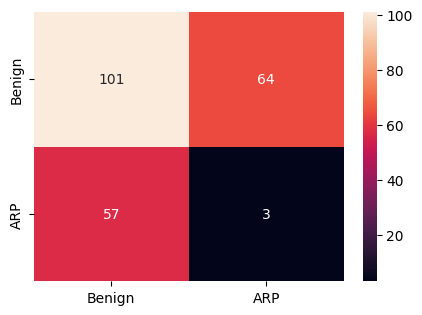





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP           1    1     0  DT    0.636    0.433   0.352  0.433  0.389  -0.167  0.433    0.012     0
 1  ARP           1    1     1  DT    0.636    0.433   0.352  0.433  0.389  -0.167  0.433    0.006     0
 2  ARP           1    1     2  DT    0.662    0.452   0.356  0.452  0.398  -0.126  0.452    0.011     0.001
 3  ARP           1    1     3  DT    0.636    0.433   0.352  0.433  0.389  -0.167  0.433    0.012     0
 4  ARP           1    1     4  DT    0.733    0.5     0.367  0.5    0.423   0      0.5      0.016     0
 5  ARP           1    1     5  DT    0.662    0.452   0.356  0.452  0.398  -0.126  0.452    0.006     0
 6  ARP           1    1     6  DT    0.733    0.5     0.367  0.5    0.423   0      0.5      0         0
 7  ARP           1    1     7  DT    0

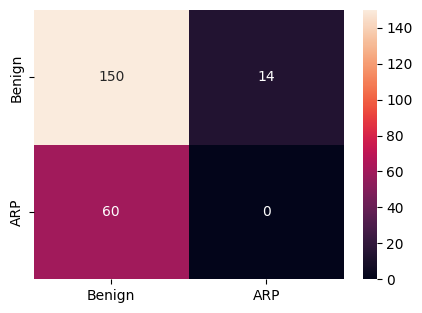





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP           1    1     0  RF    0.733    0.5     0.367  0.5    0.423   0      0.5      0.094     0
 1  ARP           1    1     1  RF    0.733    0.5     0.367  0.5    0.423   0      0.5      0.079     0.02
 2  ARP           1    1     2  RF    0.707    0.482   0.363  0.482  0.414  -0.051  0.482    0.086     0.015
 3  ARP           1    1     3  RF    0.733    0.5     0.367  0.5    0.423   0      0.5      0.079     0.016
 4  ARP           1    1     4  RF    0.733    0.5     0.367  0.5    0.423   0      0.5      0.094     0
 5  ARP           1    1     5  RF    0.702    0.479   0.362  0.479  0.413  -0.059  0.479    0.078     0.023
 6  ARP           1    1     6  RF    0.733    0.5     0.367  0.5    0.423   0      0.5      0.094     0
 7  ARP           1    1    

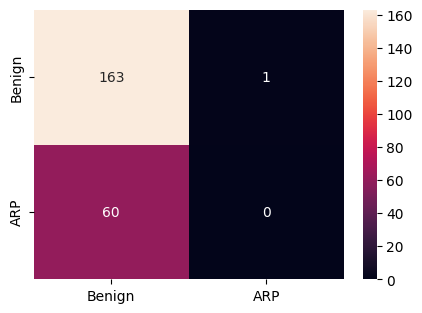





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           1    1     0  KNN   0.782    0.597   0.848  0.597  0.599  0.258  0.597    0.006     0
 1  ARP           1    1     1  KNN   0.782    0.597   0.848  0.597  0.599  0.258  0.597    0.016     0
 2  ARP           1    1     2  KNN   0.782    0.597   0.848  0.597  0.599  0.258  0.597    0         0
 3  ARP           1    1     3  KNN   0.782    0.597   0.848  0.597  0.599  0.258  0.597    0         0
 4  ARP           1    1     4  KNN   0.782    0.597   0.848  0.597  0.599  0.258  0.597    0         0
 5  ARP           1    1     5  KNN   0.782    0.597   0.848  0.597  0.599  0.258  0.597    0         0
 6  ARP           1    1     6  KNN   0.782    0.597   0.848  0.597  0.599  0.258  0.597    0         0.016
 7  ARP           1    1     7  KNN   0.782    0

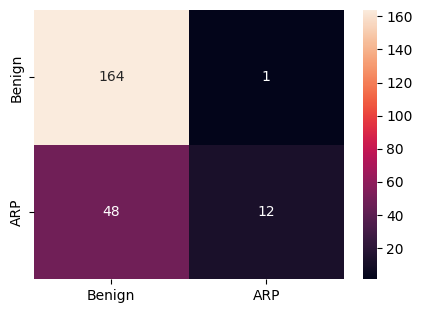





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  ARP           1    1     0  NB    0.787    0.733   0.728  0.733  0.73   0.46  0.733    0             0
 1  ARP           1    1     1  NB    0.787    0.733   0.728  0.733  0.73   0.46  0.733    0             0
 2  ARP           1    1     2  NB    0.787    0.733   0.728  0.733  0.73   0.46  0.733    0             0
 3  ARP           1    1     3  NB    0.787    0.733   0.728  0.733  0.73   0.46  0.733    0             0
 4  ARP           1    1     4  NB    0.787    0.733   0.728  0.733  0.73   0.46  0.733    0             0
 5  ARP           1    1     5  NB    0.787    0.733   0.728  0.733  0.73   0.46  0.733    0             0
 6  ARP           1    1     6  NB    0.787    0.733   0.728  0.733  0.73   0.46  0.733    0             0
 7  ARP           1    1     7  N

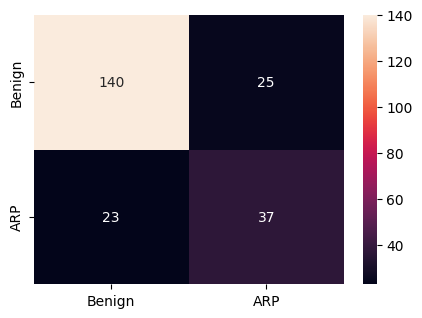





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP           1    1     0  XGB   0.636    0.433   0.352  0.433  0.389  -0.167  0.433    1.434     0
 1  ARP           1    1     1  XGB   0.636    0.433   0.352  0.433  0.389  -0.167  0.433    1.406     0
 2  ARP           1    1     2  XGB   0.636    0.433   0.352  0.433  0.389  -0.167  0.433    1.126     0
 3  ARP           1    1     3  XGB   0.636    0.433   0.352  0.433  0.389  -0.167  0.433    1.455     0
 4  ARP           1    1     4  XGB   0.636    0.433   0.352  0.433  0.389  -0.167  0.433    1.255     0
 5  ARP           1    1     5  XGB   0.636    0.433   0.352  0.433  0.389  -0.167  0.433    1.194     0.004
 6  ARP           1    1     6  XGB   0.636    0.433   0.352  0.433  0.389  -0.167  0.433    1.152     0
 7  ARP           1    1     7  XGB   0

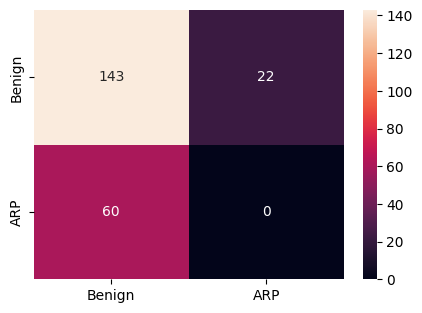





SP
['Tot Fwd Pkts', 'TotLen Fwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow IAT Std', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Header Len', 'Fwd Pkts/s', 'Pkt Len Var', 'SYN Flag Cnt', 'Fwd Seg Size Avg', 'Subflow Bwd Pkts', 'Init Bwd Win Byts', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  LR    0.999    0.994   1      0.994  0.997  0.993  0.994    0.015     0
 1  SP            1    1     1  LR    0.999    0.994   1      0.994  0.997  0.993  0.994    0         0
 2  SP            1    1     2  LR    0.999    0.994   1      0.994  0.997  0.993  0.994    0.005     0.001
 3  SP     

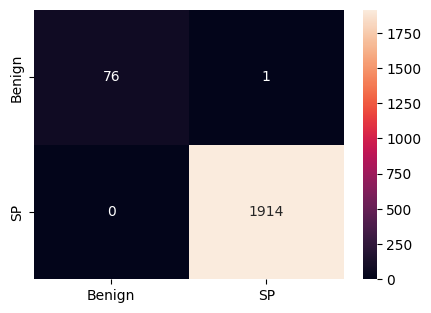





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  DT    0.999    0.987   0.999  0.987  0.993  0.986  0.987        0         0
 1  SP            1    1     1  DT    0.999    0.993   0.993  0.993  0.993  0.987  0.993        0         0
 2  SP            1    1     2  DT    0.999    0.987   0.999  0.987  0.993  0.986  0.987        0         0
 3  SP            1    1     3  DT    0.999    0.987   0.999  0.987  0.993  0.986  0.987        0         0
 4  SP            1    1     4  DT    0.999    0.994   1      0.994  0.997  0.993  0.994        0         0
 5  SP            1    1     5  DT    0.999    0.987   0.999  0.987  0.993  0.986  0.987        0         0
 6  SP            1    1     6  DT    0.999    0.987   0.999  0.987  0.993  0.986  0.987        0         0
 7  SP            1    1

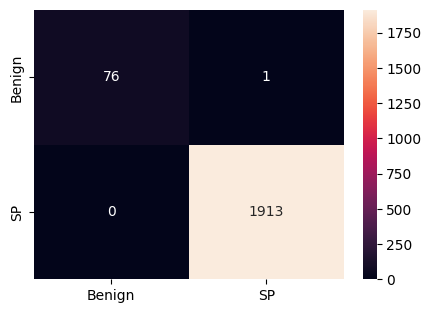





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  RF    0.999    0.994       1  0.994  0.997  0.993  0.994    0.047     0
 1  SP            1    1     1  RF    0.999    0.994       1  0.994  0.997  0.993  0.994    0.031     0.016
 2  SP            1    1     2  RF    0.999    0.994       1  0.994  0.997  0.993  0.994    0.046     0
 3  SP            1    1     3  RF    0.999    0.994       1  0.994  0.997  0.993  0.994    0.031     0.016
 4  SP            1    1     4  RF    0.999    0.994       1  0.994  0.997  0.993  0.994    0.047     0.016
 5  SP            1    1     5  RF    0.999    0.994       1  0.994  0.997  0.993  0.994    0.047     0.016
 6  SP            1    1     6  RF    0.999    0.994       1  0.994  0.997  0.993  0.994    0.042     0.012
 7  SP            1    1     7  

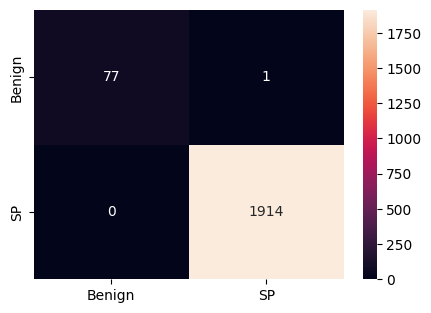





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  KNN   0.992    0.916   0.982  0.916  0.946  0.893  0.916    0.013     0.08
 1  SP            1    1     1  KNN   0.992    0.916   0.982  0.916  0.946  0.893  0.916    0.003     0.088
 2  SP            1    1     2  KNN   0.992    0.916   0.982  0.916  0.946  0.893  0.916    0         0.204
 3  SP            1    1     3  KNN   0.992    0.916   0.982  0.916  0.946  0.893  0.916    0         0.094
 4  SP            1    1     4  KNN   0.992    0.916   0.982  0.916  0.946  0.893  0.916    0         0.094
 5  SP            1    1     5  KNN   0.992    0.916   0.982  0.916  0.946  0.893  0.916    0.016     0.097
 6  SP            1    1     6  KNN   0.992    0.916   0.982  0.916  0.946  0.893  0.916    0         0.094
 7  SP            1    1 

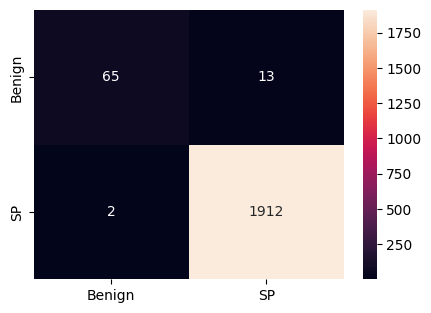





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  NB    0.996    0.949   0.998  0.949  0.972  0.944  0.949        0         0
 1  SP            1    1     1  NB    0.996    0.949   0.998  0.949  0.972  0.944  0.949        0         0
 2  SP            1    1     2  NB    0.996    0.949   0.998  0.949  0.972  0.944  0.949        0         0
 3  SP            1    1     3  NB    0.996    0.949   0.998  0.949  0.972  0.944  0.949        0         0
 4  SP            1    1     4  NB    0.996    0.949   0.998  0.949  0.972  0.944  0.949        0         0
 5  SP            1    1     5  NB    0.996    0.949   0.998  0.949  0.972  0.944  0.949        0         0
 6  SP            1    1     6  NB    0.996    0.949   0.998  0.949  0.972  0.944  0.949        0         0
 7  SP            1    1

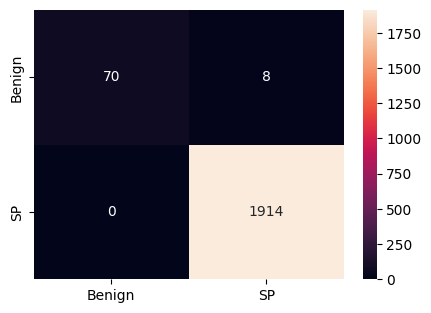





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  XGB   0.999    0.987   0.999  0.987  0.993  0.986  0.987    1.892     0.016
 1  SP            1    1     1  XGB   0.999    0.987   0.999  0.987  0.993  0.986  0.987    1.584     0.01
 2  SP            1    1     2  XGB   0.999    0.987   0.999  0.987  0.993  0.986  0.987    1.545     0.016
 3  SP            1    1     3  XGB   0.999    0.987   0.999  0.987  0.993  0.986  0.987    1.478     0.009
 4  SP            1    1     4  XGB   0.999    0.987   0.999  0.987  0.993  0.986  0.987    1.356     0.012
 5  SP            1    1     5  XGB   0.999    0.987   0.999  0.987  0.993  0.986  0.987    1.339     0.011
 6  SP            1    1     6  XGB   0.999    0.987   0.999  0.987  0.993  0.986  0.987    1.636     0.011
 7  SP            1    1 

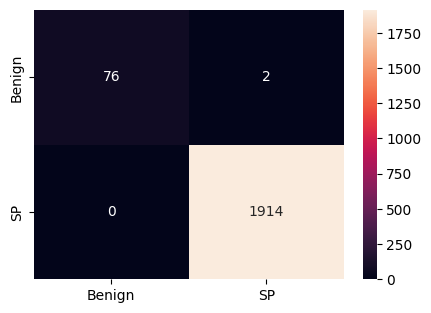





BF
['Tot Bwd Pkts', 'TotLen Fwd Pkts', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Min', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  LR    0.463      0.5   0.231    0.5  0.316      0    0.5    0             0
 1  BF            1    1     1  LR    0.463      0.5   0.231    0.5  0.316      0    0.5    0.016         0
 2  BF            1    1     2  LR    0.463      0.5   0.231    0.5  0.316      0    0.5    0.016         0
 3  BF            1    1     3  LR    0.463      0.5   0.231    0.5  0.316      0    0.5    0.003         0
 4  BF            1    1     4  LR    0.463      0.5   0.231    0.5  0.316      0    0.5    0.018         0
 5  BF            1    1     5  LR    0.463     

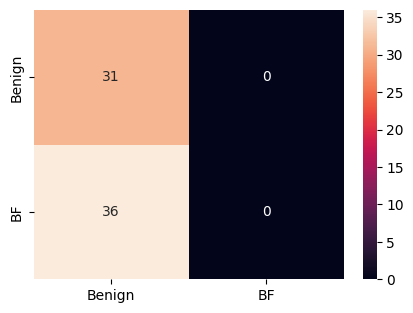





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  BF            1    1     0  DT    0.463    0.498   0.481  0.498  0.339  -0.004  0.498    0.005     0.001
 1  BF            1    1     1  DT    0.537    0.565   0.639  0.565  0.481   0.123  0.565    0         0
 2  BF            1    1     2  DT    0.552    0.581   0.692  0.581  0.492   0.153  0.581    0.016     0
 3  BF            1    1     3  DT    0.552    0.581   0.692  0.581  0.492   0.153  0.581    0         0
 4  BF            1    1     4  DT    0.478    0.514   0.735  0.514  0.347   0.026  0.514    0         0
 5  BF            1    1     5  DT    0.537    0.565   0.639  0.565  0.481   0.123  0.565    0         0
 6  BF            1    1     6  DT    0.567    0.597   0.758  0.597  0.503   0.183  0.597    0.016     0
 7  BF            1    1     7  DT    0

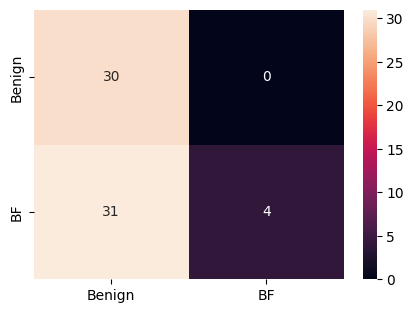





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  BF            1    1     0  RF    0.448    0.484   0.227  0.484  0.309  -0.03   0.484    0.328     0.017
 1  BF            1    1     1  RF    0.448    0.484   0.227  0.484  0.309  -0.03   0.484    0.303     0.031
 2  BF            1    1     2  RF    0.433    0.468   0.223  0.468  0.302  -0.06   0.468    0.355     0.016
 3  BF            1    1     3  RF    0.433    0.468   0.223  0.468  0.302  -0.06   0.468    0.329     0.016
 4  BF            1    1     4  RF    0.448    0.484   0.227  0.484  0.309  -0.03   0.484    0.312     0.016
 5  BF            1    1     5  RF    0.537    0.567   0.679  0.567  0.469   0.126  0.567    0.346     0.016
 6  BF            1    1     6  RF    0.448    0.484   0.227  0.484  0.309  -0.03   0.484    0.328     0.015
 7  BF         

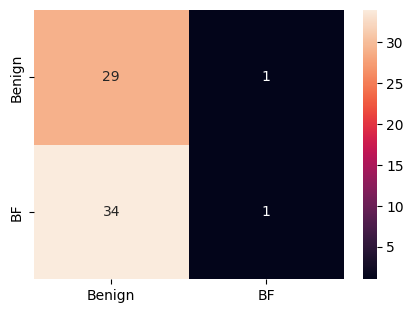





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  BF            1    1     0  KNN   0.463    0.496    0.48  0.496  0.359  -0.008  0.496    0.002     0.002
 1  BF            1    1     1  KNN   0.463    0.496    0.48  0.496  0.359  -0.008  0.496    0         0
 2  BF            1    1     2  KNN   0.463    0.496    0.48  0.496  0.359  -0.008  0.496    0         0
 3  BF            1    1     3  KNN   0.463    0.496    0.48  0.496  0.359  -0.008  0.496    0         0
 4  BF            1    1     4  KNN   0.463    0.496    0.48  0.496  0.359  -0.008  0.496    0         0
 5  BF            1    1     5  KNN   0.463    0.496    0.48  0.496  0.359  -0.008  0.496    0.006     0.001
 6  BF            1    1     6  KNN   0.463    0.496    0.48  0.496  0.359  -0.008  0.496    0         0.005
 7  BF            1    1     7 

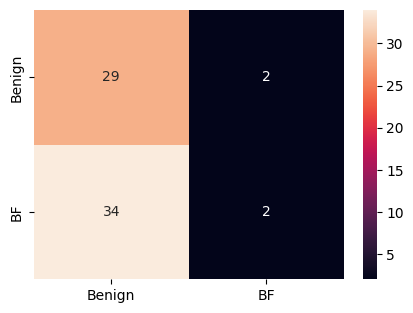





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  NB    0.701    0.722   0.804  0.722  0.686  0.425  0.722    0.001     0.001
 1  BF            1    1     1  NB    0.701    0.722   0.804  0.722  0.686  0.425  0.722    0         0
 2  BF            1    1     2  NB    0.701    0.722   0.804  0.722  0.686  0.425  0.722    0         0
 3  BF            1    1     3  NB    0.701    0.722   0.804  0.722  0.686  0.425  0.722    0         0
 4  BF            1    1     4  NB    0.701    0.722   0.804  0.722  0.686  0.425  0.722    0         0
 5  BF            1    1     5  NB    0.701    0.722   0.804  0.722  0.686  0.425  0.722    0         0
 6  BF            1    1     6  NB    0.701    0.722   0.804  0.722  0.686  0.425  0.722    0.001     0
 7  BF            1    1     7  NB    0.701    0

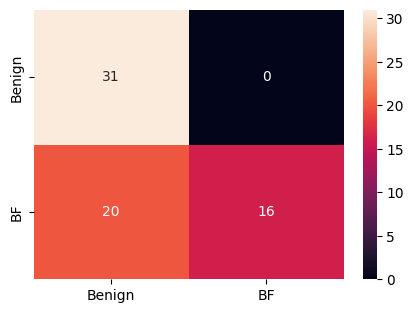





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  XGB   0.567    0.597   0.758  0.597  0.503  0.183  0.597    1.663     0.002
 1  BF            1    1     1  XGB   0.567    0.597   0.758  0.597  0.503  0.183  0.597    1.925     0
 2  BF            1    1     2  XGB   0.567    0.597   0.758  0.597  0.503  0.183  0.597    2.037     0
 3  BF            1    1     3  XGB   0.567    0.597   0.758  0.597  0.503  0.183  0.597    1.892     0
 4  BF            1    1     4  XGB   0.567    0.597   0.758  0.597  0.503  0.183  0.597    2.032     0
 5  BF            1    1     5  XGB   0.567    0.597   0.758  0.597  0.503  0.183  0.597    1.969     0.003
 6  BF            1    1     6  XGB   0.567    0.597   0.758  0.597  0.503  0.183  0.597    1.687     0.003
 7  BF            1    1     7  XGB   0.

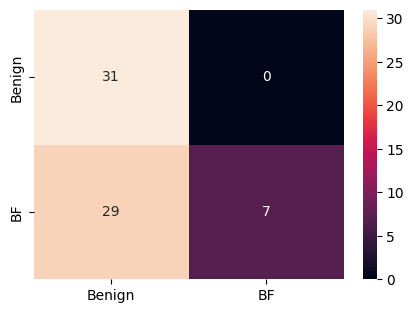

In [23]:
folder("results/test/")

for file in file_list:
    print(file)
    #if "UDP" in file:        feature=feature_list["UDP"]
    #else:        feature=feature_list[file]
    feature=feature_list[file]
    train=file_list[file][0]
    test=file_list[file][1]
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/test/{file}_TEST_chosed_output_ML_.csv"
    target_names=["Benign",file]
    ML(train,test,output_csv,feature,file,1)  


In [24]:
files_add=find_the_way("./results/test/","_.csv")
files_add

results=[['Attack', 'ML','Acc', 'b_Acc', 'Prec', 'Rec',
       'F1', 'kap', 'ROC', 'tra-T', 'test-T']]


    
for i in tqdm(files_add):
    df=pd.read_csv(i)
    temp=df.values
    df=df.mean()
    df=list(df.values)
    temp=[temp[0][0],temp[0][4]]
    temp=temp+df[3:]
    results.append(temp)
results = pd.DataFrame (results[1:], columns = results[0])
results.to_csv("MEAN-resluts.csv",index=False)
print (tabulate(results, headers=list(results.columns)))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 218.92it/s]

    Attack    ML            Acc     b_Acc         Prec       Rec           F1           kap       ROC          tra-T         test-T
--  --------  ----  -----------  --------  -----------  --------  -----------  ------------  --------  -------------  -------------
 0  ACK       DT    0.115957     0.443079  0.374875     0.443079  0.112921     -0.024188     0.443079    0.000499487    0.000400209
 1  ACK       KNN   0.102128     0.5       0.0510638    0.5       0.0926641     0            0.5         0.00317216     0.0207926
 2  ACK       LR    0.115957     0.443079  0.374875     0.443079  0.112921     -0.024188     0.443079    0.0438205      0.000300646
 3  ACK       MLP   0.127553     0.464768  0.427583     0.464768  0.124872     -0.0150568    0.464768   17.4618         0.0775397
 4  ACK       NB    0.118085     0.444263  0.382917     0.444263  0.115273     -0.0237311    0.444263    0.00122199     0.000699115
 5  ACK       RF    0.115957     0.443079  0.374875     0.443079  0.112921     -

In [25]:
df=pd.read_csv("MEAN-resluts.csv")
bos=pd.DataFrame()
for i in df["Attack"].unique():
    small=df[df["Attack"]==i]
    bos[i]=small["F1"].values
    print(i)
bos.to_csv("tablo.csv",index=False)

ACK
ARP
BF
HTTP
SP
SYN
UDP
